In [31]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [32]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [33]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [34]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [35]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [36]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [37]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [38]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [39]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [40]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [41]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [42]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [43]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [44]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [45]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [46]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [47]:
len(categorical_columns) + len(numeric_columns)

59

In [48]:
def make_feature(df):
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  # df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)

  df['IVF 시술 성공률'] = df['IVF 임신 횟수'] / (df['IVF 시술 횟수'] + 1)    
  df['DI 시술 성공률'] = df['DI 임신 횟수'] / (df['DI 시술 횟수'] + 1)         
  df['클리닉 시술 비율'] = df['총 시술 횟수'] / (df['클리닉 내 총 시술 횟수'] + 1)  
  df['배아 이용 효율'] = (df['이식된 배아 수'] + df['저장된 배아 수']) / (df['총 생성 배아 수'] + 1) 

  return df

In [49]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 70), (90067, 70))

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 70), (90067, 70))

In [51]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [52]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [53]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [54]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-24 13:47:53,022] A new study created in memory with name: no-name-278b5c15-87b6-4f02-b114-2950e4d4cdcb


Seed 4972 Start!
0:	test: 0.7222746	best: 0.7222746 (0)	total: 183ms	remaining: 7m 11s
300:	test: 0.7387276	best: 0.7387276 (300)	total: 38.1s	remaining: 4m 21s
600:	test: 0.7401148	best: 0.7401148 (600)	total: 1m 18s	remaining: 3m 50s
900:	test: 0.7407638	best: 0.7407638 (899)	total: 1m 57s	remaining: 3m 10s
1200:	test: 0.7408903	best: 0.7409123 (1186)	total: 2m 41s	remaining: 2m 36s
1500:	test: 0.7410426	best: 0.7410602 (1491)	total: 3m 29s	remaining: 2m 1s
1800:	test: 0.7410401	best: 0.7411187 (1607)	total: 4m 22s	remaining: 1m 22s


[I 2025-02-24 13:52:34,101] Trial 0 finished with value: 0.7411186767250701 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7411186767250701.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411186767
bestIteration = 1607

Shrink model to first 1608 iterations.
저장 완료
0:	test: 0.6939752	best: 0.6939752 (0)	total: 57.1ms	remaining: 2m 5s
300:	test: 0.7306007	best: 0.7306007 (300)	total: 13.3s	remaining: 1m 23s
600:	test: 0.7344322	best: 0.7344322 (600)	total: 27.2s	remaining: 1m 12s
900:	test: 0.7363272	best: 0.7363272 (900)	total: 41.2s	remaining: 59.1s
1200:	test: 0.7373517	best: 0.7373517 (1200)	total: 55.4s	remaining: 45.8s
1500:	test: 0.7380062	best: 0.7380063 (1498)	total: 1m 10s	remaining: 32.3s
1800:	test: 0.7385153	best: 0.7385153 (1800)	total: 1m 24s	remaining: 18.4s
2100:	test: 0.7389172	best: 0.7389172 (2100)	total: 1m 39s	remaining: 4.35s


[I 2025-02-24 13:54:18,321] Trial 1 finished with value: 0.7390708753125588 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7411186767250701.


2192:	test: 0.7390709	best: 0.7390709 (2192)	total: 1m 43s	remaining: 0us

bestTest = 0.7390708753
bestIteration = 2192

0:	test: 0.6939752	best: 0.6939752 (0)	total: 54.7ms	remaining: 2m 18s
300:	test: 0.7404625	best: 0.7404636 (287)	total: 14.8s	remaining: 1m 49s
600:	test: 0.7402916	best: 0.7404720 (309)	total: 30.3s	remaining: 1m 37s


[I 2025-02-24 13:54:49,272] Trial 2 finished with value: 0.7404719526478617 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7411186767250701.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404719526
bestIteration = 309

Shrink model to first 310 iterations.
0:	test: 0.6939752	best: 0.6939752 (0)	total: 50.8ms	remaining: 1m 58s
300:	test: 0.7392722	best: 0.7392722 (300)	total: 14.5s	remaining: 1m 37s
600:	test: 0.7402891	best: 0.7402891 (600)	total: 29.8s	remaining: 1m 26s
900:	test: 0.7403740	best: 0.7405008 (839)	total: 45.2s	remaining: 1m 11s


[I 2025-02-24 13:55:46,746] Trial 3 finished with value: 0.7405008472671086 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7411186767250701.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405008473
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7221312	best: 0.7221312 (0)	total: 125ms	remaining: 3m 37s
300:	test: 0.7374676	best: 0.7374794 (299)	total: 40.3s	remaining: 3m 13s
600:	test: 0.7379618	best: 0.7381034 (580)	total: 1m 23s	remaining: 2m 39s
900:	test: 0.7380853	best: 0.7381815 (844)	total: 2m 7s	remaining: 1m 58s


[I 2025-02-24 13:58:32,433] Trial 4 finished with value: 0.7381814594636049 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7411186767250701.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381814595
bestIteration = 844

Shrink model to first 845 iterations.
0:	test: 0.6939752	best: 0.6939752 (0)	total: 62.1ms	remaining: 2m 9s
300:	test: 0.7400123	best: 0.7400123 (299)	total: 15.4s	remaining: 1m 31s
600:	test: 0.7401105	best: 0.7404330 (437)	total: 31.5s	remaining: 1m 17s


[I 2025-02-24 13:59:11,622] Trial 5 finished with value: 0.740432960596054 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7411186767250701.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404329606
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.6983380	best: 0.6983380 (0)	total: 64.7ms	remaining: 2m 9s
300:	test: 0.7404462	best: 0.7404462 (299)	total: 18.7s	remaining: 1m 45s
600:	test: 0.7409965	best: 0.7410023 (578)	total: 38.3s	remaining: 1m 28s
900:	test: 0.7412444	best: 0.7412445 (898)	total: 57.9s	remaining: 1m 10s
1200:	test: 0.7412244	best: 0.7412853 (919)	total: 1m 18s	remaining: 51.8s


[I 2025-02-24 14:00:31,301] Trial 6 finished with value: 0.7412853419371452 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412853419371452.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412853419
bestIteration = 919

Shrink model to first 920 iterations.
저장 완료
0:	test: 0.7134429	best: 0.7134429 (0)	total: 82.5ms	remaining: 2m 38s
300:	test: 0.7392607	best: 0.7400982 (150)	total: 26.7s	remaining: 2m 24s


[I 2025-02-24 14:01:12,416] Trial 7 finished with value: 0.7400982483761775 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412853419371452.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400982484
bestIteration = 150

Shrink model to first 151 iterations.
0:	test: 0.7134616	best: 0.7134616 (0)	total: 79.4ms	remaining: 2m 31s
300:	test: 0.7404744	best: 0.7404820 (283)	total: 25.7s	remaining: 2m 16s
600:	test: 0.7404548	best: 0.7407875 (418)	total: 53.1s	remaining: 1m 55s


[I 2025-02-24 14:02:16,806] Trial 8 finished with value: 0.7407875023787336 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7412853419371452.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407875024
bestIteration = 418

Shrink model to first 419 iterations.
0:	test: 0.7134613	best: 0.7134613 (0)	total: 91.6ms	remaining: 4m 1s
300:	test: 0.7398433	best: 0.7398433 (300)	total: 21.7s	remaining: 2m 48s
600:	test: 0.7405744	best: 0.7405861 (512)	total: 44.6s	remaining: 2m 31s
900:	test: 0.7404720	best: 0.7406177 (607)	total: 1m 7s	remaining: 2m 11s


[I 2025-02-24 14:03:25,463] Trial 9 finished with value: 0.740617664595437 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7412853419371452.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406176646
bestIteration = 607

Shrink model to first 608 iterations.
0:	test: 0.7134624	best: 0.7134624 (0)	total: 66.8ms	remaining: 3m 16s
300:	test: 0.7409675	best: 0.7409675 (300)	total: 21.6s	remaining: 3m 9s
600:	test: 0.7415314	best: 0.7415314 (600)	total: 45.4s	remaining: 2m 56s
900:	test: 0.7415703	best: 0.7416622 (806)	total: 1m 9s	remaining: 2m 37s


[I 2025-02-24 14:04:51,969] Trial 10 finished with value: 0.7416621592198902 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416621592
bestIteration = 806

Shrink model to first 807 iterations.
저장 완료
0:	test: 0.7134825	best: 0.7134825 (0)	total: 75.4ms	remaining: 3m 45s
300:	test: 0.7408571	best: 0.7408588 (293)	total: 22.7s	remaining: 3m 23s
600:	test: 0.7413295	best: 0.7413740 (568)	total: 46.3s	remaining: 3m 4s
900:	test: 0.7413632	best: 0.7414602 (706)	total: 1m 10s	remaining: 2m 44s


[I 2025-02-24 14:06:11,755] Trial 11 finished with value: 0.7414601549791909 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741460155
bestIteration = 706

Shrink model to first 707 iterations.
0:	test: 0.7134530	best: 0.7134530 (0)	total: 73.8ms	remaining: 3m 33s
300:	test: 0.7407748	best: 0.7407748 (300)	total: 21.8s	remaining: 3m 8s
600:	test: 0.7414267	best: 0.7414277 (596)	total: 43.4s	remaining: 2m 45s
900:	test: 0.7415425	best: 0.7415768 (875)	total: 1m 6s	remaining: 2m 26s
1200:	test: 0.7415431	best: 0.7415951 (1011)	total: 1m 30s	remaining: 2m 8s


[I 2025-02-24 14:07:51,018] Trial 12 finished with value: 0.741595106391084 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415951064
bestIteration = 1011

Shrink model to first 1012 iterations.
0:	test: 0.7206242	best: 0.7206242 (0)	total: 97.9ms	remaining: 4m 51s
300:	test: 0.7404251	best: 0.7404489 (297)	total: 29.5s	remaining: 4m 21s
600:	test: 0.7401363	best: 0.7405450 (314)	total: 1m	remaining: 4m


[I 2025-02-24 14:08:53,573] Trial 13 finished with value: 0.7405449535513735 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405449536
bestIteration = 314

Shrink model to first 315 iterations.
0:	test: 0.7205435	best: 0.7205435 (0)	total: 96.6ms	remaining: 4m 26s
300:	test: 0.7397304	best: 0.7397304 (300)	total: 28s	remaining: 3m 48s
600:	test: 0.7400615	best: 0.7403441 (473)	total: 58.1s	remaining: 3m 28s


[I 2025-02-24 14:10:09,680] Trial 14 finished with value: 0.7403440809537256 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740344081
bestIteration = 473

Shrink model to first 474 iterations.
0:	test: 0.7134791	best: 0.7134791 (0)	total: 80.6ms	remaining: 2m 1s
300:	test: 0.7408126	best: 0.7408315 (292)	total: 21.7s	remaining: 1m 27s
600:	test: 0.7406388	best: 0.7409152 (458)	total: 44.1s	remaining: 1m 6s


[I 2025-02-24 14:11:06,024] Trial 15 finished with value: 0.7409152033337426 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 9.663069382488304}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409152033
bestIteration = 458

Shrink model to first 459 iterations.
0:	test: 0.7205957	best: 0.7205957 (0)	total: 93.5ms	remaining: 4m 23s
300:	test: 0.7407983	best: 0.7408816 (229)	total: 27.6s	remaining: 3m 51s


[I 2025-02-24 14:11:56,747] Trial 16 finished with value: 0.7408815875790986 and parameters: {'iterations': 2824, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408815876
bestIteration = 229

Shrink model to first 230 iterations.
0:	test: 0.6983380	best: 0.6983380 (0)	total: 56.5ms	remaining: 2m 23s
300:	test: 0.7404704	best: 0.7404737 (299)	total: 18.6s	remaining: 2m 18s
600:	test: 0.7409389	best: 0.7409860 (538)	total: 38s	remaining: 2m 2s
900:	test: 0.7412060	best: 0.7412060 (900)	total: 56.4s	remaining: 1m 42s
1200:	test: 0.7414498	best: 0.7414699 (1179)	total: 1m 15s	remaining: 1m 24s
1500:	test: 0.7414726	best: 0.7415252 (1270)	total: 1m 34s	remaining: 1m 5s


[I 2025-02-24 14:13:35,569] Trial 17 finished with value: 0.7415252184986331 and parameters: {'iterations': 2546, 'depth': 5, 'learning_rate': 0.0774911016692127, 'l2_leaf_reg': 80.62911323694684}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415252185
bestIteration = 1270

Shrink model to first 1271 iterations.
0:	test: 0.7134346	best: 0.7134346 (0)	total: 139ms	remaining: 6m 32s
300:	test: 0.7407951	best: 0.7409765 (276)	total: 24.2s	remaining: 3m 21s


[I 2025-02-24 14:14:23,409] Trial 18 finished with value: 0.7409764788269704 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7416621592198902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409764788
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.6982212	best: 0.6982212 (0)	total: 52.9ms	remaining: 2m 10s
300:	test: 0.7392047	best: 0.7392047 (300)	total: 16.8s	remaining: 2m
600:	test: 0.7406240	best: 0.7406801 (577)	total: 34.4s	remaining: 1m 46s
900:	test: 0.7409208	best: 0.7409222 (899)	total: 52.6s	remaining: 1m 31s
1200:	test: 0.7409873	best: 0.7410386 (1136)	total: 1m 11s	remaining: 1m 15s
1500:	test: 0.7408445	best: 0.7410666 (1250)	total: 1m 30s	remaining: 57.9s


[I 2025-02-24 14:15:57,452] Trial 19 finished with value: 0.7410666012913167 and parameters: {'iterations': 2460, 'depth': 5, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 10 with value: 0.7416621592198902.
[I 2025-02-24 14:15:57,457] A new study created in memory with name: no-name-219a76e1-bcb1-4a78-9a6e-ec85b7f8e0c3


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410666013
bestIteration = 1250

Shrink model to first 1251 iterations.


[I 2025-02-24 14:16:21,214] Trial 0 finished with value: 0.7306881599221124 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7306881599221124.
[I 2025-02-24 14:16:38,446] Trial 1 finished with value: 0.7407353237073684 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407353237073684.
[I 2025-02-24 14:16:58,208] Trial 2 finished with value: 0.7407260204102823 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7416621592198902
LGBM val score : 0.7412960945314726
Ensemble val score : 0.7419945525641805


[I 2025-02-24 14:28:20,331] A new study created in memory with name: no-name-92c37ccb-8ef3-4cf3-a5c0-c6c212dbfa61


0:	test: 0.7193883	best: 0.7193883 (0)	total: 167ms	remaining: 6m 33s
300:	test: 0.7332065	best: 0.7332065 (300)	total: 40s	remaining: 4m 34s
600:	test: 0.7345612	best: 0.7345612 (600)	total: 1m 22s	remaining: 4m 1s
900:	test: 0.7348685	best: 0.7348685 (900)	total: 2m 6s	remaining: 3m 25s
1200:	test: 0.7350645	best: 0.7350728 (1195)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7351199	best: 0.7351709 (1278)	total: 3m 42s	remaining: 2m 8s
1800:	test: 0.7350673	best: 0.7351789 (1585)	total: 4m 34s	remaining: 1m 26s


[I 2025-02-24 14:33:10,379] Trial 0 finished with value: 0.7351789162744091 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351789163
bestIteration = 1585

Shrink model to first 1586 iterations.
저장 완료
0:	test: 0.6861565	best: 0.6861565 (0)	total: 60ms	remaining: 2m 11s


Training has stopped (degenerate solution on iteration 253, probably too small l2-regularization, try to increase it)
[I 2025-02-24 14:33:22,191] Trial 1 finished with value: 0.7225520663404046 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351789162744091.



bestTest = 0.7225520663
bestIteration = 252

Shrink model to first 253 iterations.
0:	test: 0.6861565	best: 0.6861565 (0)	total: 102ms	remaining: 4m 17s
300:	test: 0.7342754	best: 0.7343053 (245)	total: 15.5s	remaining: 1m 55s
600:	test: 0.7344492	best: 0.7347739 (492)	total: 31.7s	remaining: 1m 42s


[I 2025-02-24 14:34:04,325] Trial 2 finished with value: 0.7347738698488309 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347738698
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.6861565	best: 0.6861565 (0)	total: 54.5ms	remaining: 2m 7s
300:	test: 0.7337105	best: 0.7337105 (300)	total: 14.5s	remaining: 1m 37s
600:	test: 0.7346337	best: 0.7346415 (573)	total: 29.7s	remaining: 1m 25s
900:	test: 0.7345432	best: 0.7347712 (679)	total: 45.2s	remaining: 1m 11s


[I 2025-02-24 14:34:53,909] Trial 3 finished with value: 0.7347712488060157 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347712488
bestIteration = 679

Shrink model to first 680 iterations.
0:	test: 0.7192503	best: 0.7192503 (0)	total: 135ms	remaining: 3m 54s
300:	test: 0.7324975	best: 0.7324975 (300)	total: 39.3s	remaining: 3m 8s
600:	test: 0.7334226	best: 0.7334226 (600)	total: 1m 21s	remaining: 2m 34s
900:	test: 0.7335431	best: 0.7336019 (849)	total: 2m 1s	remaining: 1m 53s


[I 2025-02-24 14:37:32,696] Trial 4 finished with value: 0.7336018506976811 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7336018507
bestIteration = 849

Shrink model to first 850 iterations.
0:	test: 0.6861565	best: 0.6861565 (0)	total: 60ms	remaining: 2m 4s
300:	test: 0.7343414	best: 0.7343507 (299)	total: 14.8s	remaining: 1m 27s
600:	test: 0.7346225	best: 0.7346844 (400)	total: 30.4s	remaining: 1m 14s


[I 2025-02-24 14:38:08,562] Trial 5 finished with value: 0.7346843532941417 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346843533
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.6924955	best: 0.6924955 (0)	total: 68.5ms	remaining: 2m 16s
300:	test: 0.7345623	best: 0.7345623 (300)	total: 18.5s	remaining: 1m 44s
600:	test: 0.7348370	best: 0.7349150 (541)	total: 37.2s	remaining: 1m 26s
900:	test: 0.7348871	best: 0.7349350 (710)	total: 56.4s	remaining: 1m 8s
1200:	test: 0.7348992	best: 0.7349498 (925)	total: 1m 15s	remaining: 50.1s


[I 2025-02-24 14:39:26,005] Trial 6 finished with value: 0.7349498212472627 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349498212
bestIteration = 925

Shrink model to first 926 iterations.
0:	test: 0.6988223	best: 0.6988223 (0)	total: 102ms	remaining: 3m 15s
300:	test: 0.7345187	best: 0.7345303 (190)	total: 25.7s	remaining: 2m 18s
600:	test: 0.7340807	best: 0.7347795 (410)	total: 52.4s	remaining: 1m 55s


[I 2025-02-24 14:40:28,594] Trial 7 finished with value: 0.7347795289185453 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347795289
bestIteration = 410

Shrink model to first 411 iterations.
0:	test: 0.6988219	best: 0.6988219 (0)	total: 95.1ms	remaining: 3m 1s
300:	test: 0.7347938	best: 0.7348238 (299)	total: 23.9s	remaining: 2m 7s
600:	test: 0.7346443	best: 0.7349044 (370)	total: 49.6s	remaining: 1m 47s


[I 2025-02-24 14:41:24,414] Trial 8 finished with value: 0.7349044494076229 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7351789162744091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349044494
bestIteration = 370

Shrink model to first 371 iterations.
0:	test: 0.6990035	best: 0.6990035 (0)	total: 73.1ms	remaining: 3m 12s
300:	test: 0.7344531	best: 0.7344531 (300)	total: 20.2s	remaining: 2m 36s
600:	test: 0.7351384	best: 0.7351775 (589)	total: 42.9s	remaining: 2m 25s
900:	test: 0.7349284	best: 0.7351988 (608)	total: 1m 5s	remaining: 2m 6s


[I 2025-02-24 14:42:30,953] Trial 9 finished with value: 0.7351988203146957 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7351988203146957.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351988203
bestIteration = 608

Shrink model to first 609 iterations.
저장 완료
0:	test: 0.6990035	best: 0.6990035 (0)	total: 78ms	remaining: 3m 49s
300:	test: 0.7340330	best: 0.7340356 (298)	total: 20.1s	remaining: 2m 56s
600:	test: 0.7352252	best: 0.7352411 (580)	total: 42.1s	remaining: 2m 44s
900:	test: 0.7352597	best: 0.7352891 (829)	total: 1m 4s	remaining: 2m 26s


[I 2025-02-24 14:43:53,313] Trial 10 finished with value: 0.7352890914120134 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 10 with value: 0.7352890914120134.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352890914
bestIteration = 829

Shrink model to first 830 iterations.
저장 완료
0:	test: 0.6990035	best: 0.6990035 (0)	total: 78.7ms	remaining: 3m 55s
300:	test: 0.7342223	best: 0.7342223 (299)	total: 20.1s	remaining: 3m
600:	test: 0.7353708	best: 0.7353708 (600)	total: 42.8s	remaining: 2m 50s
900:	test: 0.7353629	best: 0.7354834 (798)	total: 1m 5s	remaining: 2m 33s


[I 2025-02-24 14:45:14,484] Trial 11 finished with value: 0.7354834496793059 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354834497
bestIteration = 798

Shrink model to first 799 iterations.
저장 완료
0:	test: 0.6990035	best: 0.6990035 (0)	total: 80.6ms	remaining: 3m 53s
300:	test: 0.7340036	best: 0.7340036 (300)	total: 20.8s	remaining: 2m 59s
600:	test: 0.7347676	best: 0.7348080 (562)	total: 43s	remaining: 2m 44s
900:	test: 0.7348130	best: 0.7349403 (759)	total: 1m 5s	remaining: 2m 25s
1200:	test: 0.7348043	best: 0.7349633 (1030)	total: 1m 28s	remaining: 2m 5s


[I 2025-02-24 14:46:53,379] Trial 12 finished with value: 0.7349632997613755 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.029212148274896942, 'l2_leaf_reg': 0.021674649724666952}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349632998
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7094528	best: 0.7094528 (0)	total: 100ms	remaining: 4m 57s
300:	test: 0.7345195	best: 0.7345239 (298)	total: 26.1s	remaining: 3m 51s
600:	test: 0.7346216	best: 0.7349209 (424)	total: 55.4s	remaining: 3m 38s


[I 2025-02-24 14:48:01,585] Trial 13 finished with value: 0.734920894465649 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.028817190324280706, 'l2_leaf_reg': 0.02360051290207824}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349208945
bestIteration = 424

Shrink model to first 425 iterations.
0:	test: 0.7094525	best: 0.7094525 (0)	total: 102ms	remaining: 4m 40s
300:	test: 0.7344409	best: 0.7344409 (300)	total: 26.2s	remaining: 3m 33s
600:	test: 0.7350493	best: 0.7351188 (562)	total: 55.5s	remaining: 3m 18s


[I 2025-02-24 14:49:24,603] Trial 14 finished with value: 0.7351188427673427 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.029128395358770272, 'l2_leaf_reg': 0.4972916808888326}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351188428
bestIteration = 562

Shrink model to first 563 iterations.
0:	test: 0.6990036	best: 0.6990036 (0)	total: 82.8ms	remaining: 2m 5s
300:	test: 0.7350007	best: 0.7351440 (261)	total: 21.8s	remaining: 1m 27s


[I 2025-02-24 14:50:06,347] Trial 15 finished with value: 0.7351439928645366 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.06488034830683886, 'l2_leaf_reg': 0.004468246660190198}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351439929
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.7094498	best: 0.7094498 (0)	total: 110ms	remaining: 5m 6s
300:	test: 0.7347150	best: 0.7347179 (298)	total: 27s	remaining: 3m 43s
600:	test: 0.7352867	best: 0.7353052 (577)	total: 55.5s	remaining: 3m 21s
900:	test: 0.7350114	best: 0.7353266 (620)	total: 1m 24s	remaining: 2m 57s


[I 2025-02-24 14:51:33,147] Trial 16 finished with value: 0.7353265961519311 and parameters: {'iterations': 2789, 'depth': 8, 'learning_rate': 0.03800764513988635, 'l2_leaf_reg': 2.313771052051698}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353265962
bestIteration = 620

Shrink model to first 621 iterations.
0:	test: 0.7157325	best: 0.7157325 (0)	total: 107ms	remaining: 4m 53s
300:	test: 0.7350320	best: 0.7351361 (257)	total: 30.5s	remaining: 4m 7s


[I 2025-02-24 14:52:32,540] Trial 17 finished with value: 0.7351360741382134 and parameters: {'iterations': 2740, 'depth': 9, 'learning_rate': 0.06282574574562394, 'l2_leaf_reg': 3.8044165173176334}. Best is trial 11 with value: 0.7354834496793059.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351360741
bestIteration = 257

Shrink model to first 258 iterations.
0:	test: 0.7094423	best: 0.7094423 (0)	total: 96.6ms	remaining: 4m 6s
300:	test: 0.7340577	best: 0.7340577 (300)	total: 24.9s	remaining: 3m 6s
600:	test: 0.7349169	best: 0.7349309 (589)	total: 49.4s	remaining: 2m 40s
900:	test: 0.7353731	best: 0.7353829 (891)	total: 1m 17s	remaining: 2m 21s
1200:	test: 0.7355187	best: 0.7355303 (1154)	total: 1m 45s	remaining: 1m 58s
1500:	test: 0.7355232	best: 0.7355487 (1471)	total: 2m 13s	remaining: 1m 33s
1800:	test: 0.7355716	best: 0.7356173 (1602)	total: 2m 42s	remaining: 1m 7s


[I 2025-02-24 14:55:25,069] Trial 18 finished with value: 0.7356172658288469 and parameters: {'iterations': 2551, 'depth': 8, 'learning_rate': 0.01958373252715346, 'l2_leaf_reg': 27.476376202913034}. Best is trial 18 with value: 0.7356172658288469.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7356172658
bestIteration = 1602

Shrink model to first 1603 iterations.
저장 완료
0:	test: 0.6988963	best: 0.6988963 (0)	total: 86.9ms	remaining: 3m 37s
300:	test: 0.7334523	best: 0.7334523 (300)	total: 22.4s	remaining: 2m 44s
600:	test: 0.7346656	best: 0.7346656 (599)	total: 44.4s	remaining: 2m 20s
900:	test: 0.7349212	best: 0.7349222 (890)	total: 1m 8s	remaining: 2m 2s
1200:	test: 0.7351197	best: 0.7351197 (1200)	total: 1m 33s	remaining: 1m 41s
1500:	test: 0.7353339	best: 0.7353411 (1499)	total: 1m 57s	remaining: 1m 18s
1800:	test: 0.7354291	best: 0.7354433 (1787)	total: 2m 22s	remaining: 55.6s
2100:	test: 0.7354928	best: 0.7355037 (1947)	total: 2m 46s	remaining: 32s
2400:	test: 0.7355370	best: 0.7355392 (2367)	total: 3m 10s	remaining: 8.35s


[I 2025-02-24 14:58:44,829] Trial 19 finished with value: 0.7355569818440999 and parameters: {'iterations': 2506, 'depth': 7, 'learning_rate': 0.019635316366982188, 'l2_leaf_reg': 82.64355742461473}. Best is trial 18 with value: 0.7356172658288469.
[I 2025-02-24 14:58:44,835] A new study created in memory with name: no-name-698ab23f-d6a7-4ae7-8c39-3ad3d7255e89


2505:	test: 0.7355451	best: 0.7355570 (2493)	total: 3m 19s	remaining: 0us

bestTest = 0.7355569818
bestIteration = 2493

Shrink model to first 2494 iterations.


[I 2025-02-24 14:59:08,025] Trial 0 finished with value: 0.7243407652393425 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7243407652393425.
[I 2025-02-24 14:59:25,012] Trial 1 finished with value: 0.7348860107685464 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7348860107685464.
[I 2025-02-24 14:59:44,772] Trial 2 finished with value: 0.7348877740155312 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7356172658288469
LGBM val score : 0.7350176069742487
Ensemble val score : 0.735631590224959


[I 2025-02-24 15:12:49,221] A new study created in memory with name: no-name-fc930d55-fee2-46b4-b55f-f586faf62d2c


0:	test: 0.7260631	best: 0.7260631 (0)	total: 153ms	remaining: 6m 1s
300:	test: 0.7400682	best: 0.7400682 (300)	total: 37.6s	remaining: 4m 18s
600:	test: 0.7416575	best: 0.7416575 (600)	total: 1m 17s	remaining: 3m 48s
900:	test: 0.7422328	best: 0.7422328 (900)	total: 1m 56s	remaining: 3m 9s
1200:	test: 0.7425326	best: 0.7425419 (1168)	total: 2m 41s	remaining: 2m 36s


[I 2025-02-24 15:16:13,431] Trial 0 finished with value: 0.7425418504686179 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425418505
bestIteration = 1168

Shrink model to first 1169 iterations.
저장 완료
0:	test: 0.6898011	best: 0.6898011 (0)	total: 57ms	remaining: 2m 4s
300:	test: 0.7295278	best: 0.7295278 (300)	total: 12.8s	remaining: 1m 20s
600:	test: 0.7343960	best: 0.7343960 (600)	total: 26s	remaining: 1m 8s
900:	test: 0.7367888	best: 0.7367888 (900)	total: 39.3s	remaining: 56.3s
1200:	test: 0.7380153	best: 0.7380153 (1200)	total: 53.4s	remaining: 44.1s
1500:	test: 0.7387961	best: 0.7387961 (1500)	total: 1m 7s	remaining: 31.2s
1800:	test: 0.7393858	best: 0.7393858 (1800)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7398901	best: 0.7398908 (2098)	total: 1m 35s	remaining: 4.2s


[I 2025-02-24 15:17:54,020] Trial 1 finished with value: 0.7400304585825753 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7425418504686179.


2192:	test: 0.7400305	best: 0.7400305 (2192)	total: 1m 40s	remaining: 0us

bestTest = 0.7400304586
bestIteration = 2192

0:	test: 0.6898011	best: 0.6898011 (0)	total: 53.2ms	remaining: 2m 14s
300:	test: 0.7419437	best: 0.7419616 (291)	total: 14.6s	remaining: 1m 48s


[I 2025-02-24 15:18:23,948] Trial 2 finished with value: 0.7419807130008473 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7425418504686179.


600:	test: 0.7416965	best: 0.7419807 (303)	total: 29.6s	remaining: 1m 35s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741980713
bestIteration = 303

Shrink model to first 304 iterations.
0:	test: 0.6898011	best: 0.6898011 (0)	total: 52.2ms	remaining: 2m 1s
300:	test: 0.7404638	best: 0.7404788 (299)	total: 13.9s	remaining: 1m 34s
600:	test: 0.7416005	best: 0.7416267 (592)	total: 28.9s	remaining: 1m 23s
900:	test: 0.7415486	best: 0.7416505 (637)	total: 44.1s	remaining: 1m 10s


[I 2025-02-24 15:19:10,028] Trial 3 finished with value: 0.7416504774912547 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416504775
bestIteration = 637

Shrink model to first 638 iterations.
0:	test: 0.7259878	best: 0.7259878 (0)	total: 136ms	remaining: 3m 57s
300:	test: 0.7398156	best: 0.7398156 (300)	total: 39s	remaining: 3m 6s
600:	test: 0.7410672	best: 0.7410672 (600)	total: 1m 19s	remaining: 2m 31s
900:	test: 0.7397078	best: 0.7414293 (751)	total: 2m 1s	remaining: 1m 53s


[I 2025-02-24 15:21:34,590] Trial 4 finished with value: 0.7414292972191545 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414292972
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.6898011	best: 0.6898011 (0)	total: 61ms	remaining: 2m 6s
300:	test: 0.7412275	best: 0.7412411 (264)	total: 14.6s	remaining: 1m 26s
600:	test: 0.7415593	best: 0.7417143 (431)	total: 29.9s	remaining: 1m 13s


[I 2025-02-24 15:22:11,209] Trial 5 finished with value: 0.7417142720848631 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417142721
bestIteration = 431

Shrink model to first 432 iterations.
0:	test: 0.6969185	best: 0.6969185 (0)	total: 62.8ms	remaining: 2m 5s
300:	test: 0.7415742	best: 0.7415742 (298)	total: 17.6s	remaining: 1m 38s
600:	test: 0.7420882	best: 0.7421075 (580)	total: 36.5s	remaining: 1m 24s
900:	test: 0.7422319	best: 0.7422319 (900)	total: 55.6s	remaining: 1m 7s
1200:	test: 0.7421036	best: 0.7422804 (1095)	total: 1m 15s	remaining: 49.9s


[I 2025-02-24 15:23:38,878] Trial 6 finished with value: 0.7422804093903672 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422804094
bestIteration = 1095

Shrink model to first 1096 iterations.
0:	test: 0.7036574	best: 0.7036574 (0)	total: 86.1ms	remaining: 2m 45s
300:	test: 0.7406782	best: 0.7411396 (205)	total: 25.1s	remaining: 2m 15s


[I 2025-02-24 15:24:22,141] Trial 7 finished with value: 0.7411396084476559 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411396084
bestIteration = 205

Shrink model to first 206 iterations.
0:	test: 0.7036573	best: 0.7036573 (0)	total: 89.9ms	remaining: 2m 51s
300:	test: 0.7420369	best: 0.7420460 (296)	total: 23.9s	remaining: 2m 7s
600:	test: 0.7422196	best: 0.7423506 (538)	total: 49.8s	remaining: 1m 48s


[I 2025-02-24 15:25:33,075] Trial 8 finished with value: 0.7423506017112105 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423506017
bestIteration = 538

Shrink model to first 539 iterations.
0:	test: 0.7036353	best: 0.7036353 (0)	total: 74.5ms	remaining: 3m 16s
300:	test: 0.7412993	best: 0.7412993 (300)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7422456	best: 0.7423070 (509)	total: 41.4s	remaining: 2m 20s
900:	test: 0.7422609	best: 0.7423532 (862)	total: 1m 3s	remaining: 2m 2s


[I 2025-02-24 15:26:56,191] Trial 9 finished with value: 0.7423532148114717 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7425418504686179.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423532148
bestIteration = 862

Shrink model to first 863 iterations.
0:	test: 0.7257084	best: 0.7257084 (0)	total: 135ms	remaining: 6m 37s
300:	test: 0.7418515	best: 0.7418591 (298)	total: 39s	remaining: 5m 42s
600:	test: 0.7427567	best: 0.7427689 (598)	total: 1m 20s	remaining: 5m 12s
900:	test: 0.7428398	best: 0.7429152 (855)	total: 2m 12s	remaining: 5m 1s


[I 2025-02-24 15:29:54,763] Trial 10 finished with value: 0.7429152418452885 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7429152418452885.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429152418
bestIteration = 855

Shrink model to first 856 iterations.
저장 완료
0:	test: 0.7258149	best: 0.7258149 (0)	total: 139ms	remaining: 6m 54s
300:	test: 0.7415633	best: 0.7415802 (294)	total: 39.8s	remaining: 5m 56s
600:	test: 0.7425708	best: 0.7425715 (594)	total: 1m 23s	remaining: 5m 34s
900:	test: 0.7428669	best: 0.7428787 (862)	total: 2m 19s	remaining: 5m 24s


[I 2025-02-24 15:33:01,981] Trial 11 finished with value: 0.742878745809727 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7429152418452885.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428787458
bestIteration = 862

Shrink model to first 863 iterations.
0:	test: 0.7222010	best: 0.7222010 (0)	total: 125ms	remaining: 6m
300:	test: 0.7418439	best: 0.7418439 (300)	total: 29.3s	remaining: 4m 13s
600:	test: 0.7427163	best: 0.7427163 (600)	total: 59.8s	remaining: 3m 48s
900:	test: 0.7429969	best: 0.7429990 (832)	total: 1m 33s	remaining: 3m 28s
1200:	test: 0.7432313	best: 0.7432521 (1181)	total: 2m 7s	remaining: 3m
1500:	test: 0.7433324	best: 0.7433379 (1444)	total: 2m 41s	remaining: 2m 30s


[I 2025-02-24 15:36:12,293] Trial 12 finished with value: 0.7433378849992207 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743337885
bestIteration = 1444

Shrink model to first 1445 iterations.
저장 완료
0:	test: 0.7221847	best: 0.7221847 (0)	total: 127ms	remaining: 6m 17s
300:	test: 0.7417945	best: 0.7417945 (300)	total: 30.7s	remaining: 4m 32s
600:	test: 0.7425000	best: 0.7425215 (586)	total: 1m 3s	remaining: 4m 11s


[I 2025-02-24 15:37:50,044] Trial 13 finished with value: 0.742521453989984 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02975441117748237, 'l2_leaf_reg': 7.828901342687942}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742521454
bestIteration = 586

Shrink model to first 587 iterations.
0:	test: 0.7158267	best: 0.7158267 (0)	total: 106ms	remaining: 4m 51s
300:	test: 0.7411538	best: 0.7411538 (300)	total: 26.7s	remaining: 3m 37s
600:	test: 0.7422009	best: 0.7422531 (584)	total: 54.3s	remaining: 3m 14s
900:	test: 0.7419722	best: 0.7424164 (693)	total: 1m 23s	remaining: 2m 51s


[I 2025-02-24 15:39:22,763] Trial 14 finished with value: 0.7424164017997001 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424164018
bestIteration = 693

Shrink model to first 694 iterations.
0:	test: 0.7222053	best: 0.7222053 (0)	total: 109ms	remaining: 2m 44s
300:	test: 0.7425733	best: 0.7426733 (279)	total: 30.5s	remaining: 2m 2s


[I 2025-02-24 15:40:24,776] Trial 15 finished with value: 0.7426732520817474 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.06221445398551971, 'l2_leaf_reg': 9.663069382488304}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426732521
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7221852	best: 0.7221852 (0)	total: 110ms	remaining: 5m 9s
300:	test: 0.7421271	best: 0.7421271 (300)	total: 29.1s	remaining: 4m 3s
600:	test: 0.7423193	best: 0.7424847 (484)	total: 1m 2s	remaining: 3m 52s
900:	test: 0.7421932	best: 0.7425431 (688)	total: 1m 36s	remaining: 3m 26s


[I 2025-02-24 15:42:11,537] Trial 16 finished with value: 0.7425431053921474 and parameters: {'iterations': 2824, 'depth': 9, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425431054
bestIteration = 688

Shrink model to first 689 iterations.
0:	test: 0.7158880	best: 0.7158880 (0)	total: 96.7ms	remaining: 4m 6s
300:	test: 0.7409141	best: 0.7409141 (300)	total: 25.2s	remaining: 3m 8s
600:	test: 0.7420335	best: 0.7420335 (600)	total: 49.4s	remaining: 2m 39s
900:	test: 0.7422986	best: 0.7423021 (895)	total: 1m 17s	remaining: 2m 21s
1200:	test: 0.7424834	best: 0.7424834 (1200)	total: 1m 45s	remaining: 1m 58s
1500:	test: 0.7425785	best: 0.7425883 (1425)	total: 2m 14s	remaining: 1m 33s
1800:	test: 0.7426799	best: 0.7426801 (1746)	total: 2m 42s	remaining: 1m 7s
2100:	test: 0.7426848	best: 0.7427359 (1849)	total: 3m 11s	remaining: 40.5s


[I 2025-02-24 15:45:27,701] Trial 17 finished with value: 0.7427359386890748 and parameters: {'iterations': 2546, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 80.62911323694684}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427359387
bestIteration = 1849

Shrink model to first 1850 iterations.
0:	test: 0.7158267	best: 0.7158267 (0)	total: 98.3ms	remaining: 4m 36s
300:	test: 0.7412083	best: 0.7412095 (299)	total: 25.5s	remaining: 3m 32s
600:	test: 0.7413559	best: 0.7417178 (419)	total: 53.9s	remaining: 3m 18s


[I 2025-02-24 15:46:33,259] Trial 18 finished with value: 0.7417178462341564 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.038994196866933575, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7433378849992207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417178462
bestIteration = 419

Shrink model to first 420 iterations.
0:	test: 0.7221856	best: 0.7221856 (0)	total: 107ms	remaining: 4m 23s
300:	test: 0.7409667	best: 0.7416302 (215)	total: 30.2s	remaining: 3m 36s


[I 2025-02-24 15:47:28,553] Trial 19 finished with value: 0.7416301683807148 and parameters: {'iterations': 2460, 'depth': 9, 'learning_rate': 0.06108415238553991, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 12 with value: 0.7433378849992207.
[I 2025-02-24 15:47:28,559] A new study created in memory with name: no-name-85cc80b6-5759-42b6-866c-df4f7e94a085


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416301684
bestIteration = 215

Shrink model to first 216 iterations.


[I 2025-02-24 15:47:51,686] Trial 0 finished with value: 0.7335323573215884 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7335323573215884.
[I 2025-02-24 15:48:08,642] Trial 1 finished with value: 0.7424698353316349 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7424698353316349.
[I 2025-02-24 15:48:28,259] Trial 2 finished with value: 0.741950535266981 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7433378849992207
LGBM val score : 0.7428804455162797
Ensemble val score : 0.7434589136368457


[I 2025-02-24 15:59:52,294] A new study created in memory with name: no-name-a1e9f2b3-9448-46ca-8bd9-48c3769a55b0


0:	test: 0.7255051	best: 0.7255051 (0)	total: 166ms	remaining: 6m 31s
300:	test: 0.7390583	best: 0.7390583 (300)	total: 40.1s	remaining: 4m 34s
600:	test: 0.7406513	best: 0.7406525 (599)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7412180	best: 0.7412190 (899)	total: 2m 1s	remaining: 3m 17s
1200:	test: 0.7416052	best: 0.7416238 (1170)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7417580	best: 0.7417722 (1494)	total: 3m 36s	remaining: 2m 4s
1800:	test: 0.7418534	best: 0.7418761 (1789)	total: 4m 24s	remaining: 1m 23s
2100:	test: 0.7417335	best: 0.7418794 (1848)	total: 5m 13s	remaining: 39.5s


[I 2025-02-24 16:05:13,908] Trial 0 finished with value: 0.7418794383985143 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418794384
bestIteration = 1848

Shrink model to first 1849 iterations.
저장 완료
0:	test: 0.6927403	best: 0.6927403 (0)	total: 57ms	remaining: 2m 4s
300:	test: 0.7299242	best: 0.7299242 (300)	total: 12.9s	remaining: 1m 20s


Training has stopped (degenerate solution on iteration 463, probably too small l2-regularization, try to increase it)
[I 2025-02-24 16:05:33,886] Trial 1 finished with value: 0.7328286808153684 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7418794383985143.



bestTest = 0.7328286808
bestIteration = 462

Shrink model to first 463 iterations.
0:	test: 0.6927403	best: 0.6927403 (0)	total: 57.6ms	remaining: 2m 25s
300:	test: 0.7395916	best: 0.7397357 (221)	total: 14.2s	remaining: 1m 45s


[I 2025-02-24 16:05:59,089] Trial 2 finished with value: 0.7397356601688885 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397356602
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.6927403	best: 0.6927403 (0)	total: 53ms	remaining: 2m 3s
300:	test: 0.7395616	best: 0.7395616 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7404216	best: 0.7404225 (581)	total: 28.1s	remaining: 1m 21s
900:	test: 0.7403624	best: 0.7404928 (723)	total: 42.8s	remaining: 1m 8s


[I 2025-02-24 16:06:48,198] Trial 3 finished with value: 0.7404928366959698 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404928367
bestIteration = 723

Shrink model to first 724 iterations.
0:	test: 0.7254912	best: 0.7254912 (0)	total: 133ms	remaining: 3m 51s
300:	test: 0.7383407	best: 0.7383634 (296)	total: 36.6s	remaining: 2m 55s
600:	test: 0.7393539	best: 0.7393718 (568)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7395011	best: 0.7395431 (889)	total: 1m 56s	remaining: 1m 48s
1200:	test: 0.7389226	best: 0.7395768 (916)	total: 2m 39s	remaining: 1m 11s


[I 2025-02-24 16:09:30,717] Trial 4 finished with value: 0.7395768167781316 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7395768168
bestIteration = 916

Shrink model to first 917 iterations.
0:	test: 0.6927403	best: 0.6927403 (0)	total: 51.5ms	remaining: 1m 47s
300:	test: 0.7400885	best: 0.7400885 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7402598	best: 0.7404788 (412)	total: 28.8s	remaining: 1m 10s


[I 2025-02-24 16:10:05,160] Trial 5 finished with value: 0.7404788075549382 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404788076
bestIteration = 412

Shrink model to first 413 iterations.
0:	test: 0.6993296	best: 0.6993296 (0)	total: 62.5ms	remaining: 2m 4s
300:	test: 0.7407090	best: 0.7407090 (299)	total: 17.4s	remaining: 1m 37s
600:	test: 0.7410954	best: 0.7411028 (598)	total: 35.4s	remaining: 1m 22s
900:	test: 0.7411215	best: 0.7411260 (884)	total: 53.2s	remaining: 1m 4s
1200:	test: 0.7410457	best: 0.7411453 (966)	total: 1m 11s	remaining: 47.3s


[I 2025-02-24 16:11:20,678] Trial 6 finished with value: 0.7411453366912841 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411453367
bestIteration = 966

Shrink model to first 967 iterations.
0:	test: 0.7070619	best: 0.7070619 (0)	total: 85.3ms	remaining: 2m 44s
300:	test: 0.7395968	best: 0.7402519 (151)	total: 24s	remaining: 2m 9s


[I 2025-02-24 16:11:57,425] Trial 7 finished with value: 0.7402518992034053 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402518992
bestIteration = 151

Shrink model to first 152 iterations.
0:	test: 0.7070616	best: 0.7070616 (0)	total: 84.3ms	remaining: 2m 40s
300:	test: 0.7408543	best: 0.7408742 (296)	total: 23.4s	remaining: 2m 4s
600:	test: 0.7407190	best: 0.7410234 (393)	total: 48.6s	remaining: 1m 45s


[I 2025-02-24 16:12:54,023] Trial 8 finished with value: 0.7410233550373504 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741023355
bestIteration = 393

Shrink model to first 394 iterations.
0:	test: 0.7073575	best: 0.7073575 (0)	total: 74.4ms	remaining: 3m 16s
300:	test: 0.7399809	best: 0.7399809 (300)	total: 19.4s	remaining: 2m 30s
600:	test: 0.7406110	best: 0.7406252 (589)	total: 40.5s	remaining: 2m 17s
900:	test: 0.7403619	best: 0.7406748 (609)	total: 1m 2s	remaining: 2m


[I 2025-02-24 16:13:57,082] Trial 9 finished with value: 0.7406747588774641 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406747589
bestIteration = 609

Shrink model to first 610 iterations.
0:	test: 0.7253226	best: 0.7253226 (0)	total: 131ms	remaining: 6m 26s
300:	test: 0.7408189	best: 0.7408228 (298)	total: 37s	remaining: 5m 25s
600:	test: 0.7415294	best: 0.7415428 (580)	total: 1m 17s	remaining: 5m 2s
900:	test: 0.7416862	best: 0.7416862 (900)	total: 2m 12s	remaining: 5m 1s
1200:	test: 0.7417369	best: 0.7417538 (1168)	total: 3m 6s	remaining: 4m 30s


[I 2025-02-24 16:17:52,875] Trial 10 finished with value: 0.7417538035292538 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417538035
bestIteration = 1168

Shrink model to first 1169 iterations.
0:	test: 0.7253973	best: 0.7253973 (0)	total: 127ms	remaining: 6m 19s
300:	test: 0.7407156	best: 0.7407156 (300)	total: 35.9s	remaining: 5m 21s
600:	test: 0.7413647	best: 0.7413648 (599)	total: 1m 16s	remaining: 5m 6s
900:	test: 0.7416961	best: 0.7417024 (876)	total: 2m 8s	remaining: 4m 57s


[I 2025-02-24 16:20:50,597] Trial 11 finished with value: 0.7417024043779624 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417024044
bestIteration = 876

Shrink model to first 877 iterations.
0:	test: 0.7212620	best: 0.7212620 (0)	total: 110ms	remaining: 5m 12s
300:	test: 0.7404086	best: 0.7404134 (297)	total: 28.2s	remaining: 3m 57s
600:	test: 0.7409071	best: 0.7410139 (548)	total: 58.7s	remaining: 3m 38s
900:	test: 0.7408069	best: 0.7410560 (776)	total: 1m 32s	remaining: 3m 17s


[I 2025-02-24 16:22:42,219] Trial 12 finished with value: 0.7410560235183201 and parameters: {'iterations': 2834, 'depth': 9, 'learning_rate': 0.02599223527222509, 'l2_leaf_reg': 4.031595942972541}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410560235
bestIteration = 776

Shrink model to first 777 iterations.
0:	test: 0.7212504	best: 0.7212504 (0)	total: 108ms	remaining: 4m 24s
300:	test: 0.7405176	best: 0.7405176 (300)	total: 27.8s	remaining: 3m 17s
600:	test: 0.7413785	best: 0.7413908 (598)	total: 57.2s	remaining: 2m 54s
900:	test: 0.7417868	best: 0.7417895 (894)	total: 1m 30s	remaining: 2m 34s
1200:	test: 0.7416970	best: 0.7418512 (960)	total: 2m 3s	remaining: 2m 7s


[I 2025-02-24 16:24:52,386] Trial 13 finished with value: 0.7418512371645472 and parameters: {'iterations': 2440, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 10.229612344837278}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418512372
bestIteration = 960

Shrink model to first 961 iterations.
0:	test: 0.7171538	best: 0.7171538 (0)	total: 98ms	remaining: 3m 52s
300:	test: 0.7393965	best: 0.7394015 (299)	total: 26s	remaining: 2m 59s
600:	test: 0.7406153	best: 0.7406153 (600)	total: 53.5s	remaining: 2m 37s
900:	test: 0.7411371	best: 0.7411520 (889)	total: 1m 22s	remaining: 2m 14s
1200:	test: 0.7412020	best: 0.7412925 (1143)	total: 1m 51s	remaining: 1m 48s


[I 2025-02-24 16:27:08,311] Trial 14 finished with value: 0.7412924659676785 and parameters: {'iterations': 2370, 'depth': 8, 'learning_rate': 0.017758727932018253, 'l2_leaf_reg': 5.108626929126313}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741292466
bestIteration = 1143

Shrink model to first 1144 iterations.
0:	test: 0.7212638	best: 0.7212638 (0)	total: 114ms	remaining: 2m 52s
300:	test: 0.7402474	best: 0.7402474 (300)	total: 28.8s	remaining: 1m 56s
600:	test: 0.7398180	best: 0.7405060 (402)	total: 1m 2s	remaining: 1m 34s


[I 2025-02-24 16:28:22,901] Trial 15 finished with value: 0.7405060438635529 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.03632686569864703, 'l2_leaf_reg': 0.028369951060622515}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405060439
bestIteration = 402

Shrink model to first 403 iterations.
0:	test: 0.7212620	best: 0.7212620 (0)	total: 116ms	remaining: 5m 1s
300:	test: 0.7411897	best: 0.7412482 (250)	total: 32.2s	remaining: 4m 5s


[I 2025-02-24 16:29:23,875] Trial 16 finished with value: 0.7412482024989326 and parameters: {'iterations': 2597, 'depth': 9, 'learning_rate': 0.06522242113054028, 'l2_leaf_reg': 4.362107830119581}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412482025
bestIteration = 250

Shrink model to first 251 iterations.
0:	test: 0.7171546	best: 0.7171546 (0)	total: 105ms	remaining: 4m 16s
300:	test: 0.7352720	best: 0.7352720 (300)	total: 24.8s	remaining: 2m 56s
600:	test: 0.7380855	best: 0.7380855 (600)	total: 51.4s	remaining: 2m 38s
900:	test: 0.7392220	best: 0.7392220 (900)	total: 1m 17s	remaining: 2m 13s
1200:	test: 0.7398547	best: 0.7398547 (1200)	total: 1m 44s	remaining: 1m 48s
1500:	test: 0.7402086	best: 0.7402132 (1487)	total: 2m 12s	remaining: 1m 23s
1800:	test: 0.7404726	best: 0.7404726 (1800)	total: 2m 40s	remaining: 57.9s
2100:	test: 0.7406651	best: 0.7406683 (2097)	total: 3m 8s	remaining: 31.4s
2400:	test: 0.7409744	best: 0.7409755 (2398)	total: 3m 39s	remaining: 4.67s


[I 2025-02-24 16:33:08,917] Trial 17 finished with value: 0.7410187130713537 and parameters: {'iterations': 2452, 'depth': 8, 'learning_rate': 0.005523304611431277, 'l2_leaf_reg': 0.3285101342399455}. Best is trial 0 with value: 0.7418794383985143.


2451:	test: 0.7410187	best: 0.7410187 (2444)	total: 3m 44s	remaining: 0us

bestTest = 0.7410187131
bestIteration = 2444

Shrink model to first 2445 iterations.
0:	test: 0.7171473	best: 0.7171473 (0)	total: 103ms	remaining: 4m 36s
300:	test: 0.7407444	best: 0.7407499 (298)	total: 25s	remaining: 3m 18s
600:	test: 0.7415711	best: 0.7415712 (597)	total: 52.8s	remaining: 3m 4s
900:	test: 0.7415212	best: 0.7417074 (722)	total: 1m 21s	remaining: 2m 43s


[I 2025-02-24 16:34:42,569] Trial 18 finished with value: 0.7417074315199228 and parameters: {'iterations': 2695, 'depth': 8, 'learning_rate': 0.035020115869573744, 'l2_leaf_reg': 13.010060937715274}. Best is trial 0 with value: 0.7418794383985143.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417074315
bestIteration = 722

Shrink model to first 723 iterations.
0:	test: 0.7212638	best: 0.7212638 (0)	total: 130ms	remaining: 4m 44s
300:	test: 0.7395580	best: 0.7395734 (295)	total: 28.3s	remaining: 2m 57s
600:	test: 0.7404535	best: 0.7404630 (589)	total: 56.5s	remaining: 2m 29s
900:	test: 0.7403062	best: 0.7405416 (788)	total: 1m 27s	remaining: 2m 5s


[I 2025-02-24 16:36:31,187] Trial 19 finished with value: 0.7405416230041253 and parameters: {'iterations': 2189, 'depth': 9, 'learning_rate': 0.01770769136411944, 'l2_leaf_reg': 0.01183860899423477}. Best is trial 0 with value: 0.7418794383985143.
[I 2025-02-24 16:36:31,198] A new study created in memory with name: no-name-dcc24a08-1ac3-42af-9393-39aa75e2327a


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740541623
bestIteration = 788

Shrink model to first 789 iterations.


[I 2025-02-24 16:36:54,453] Trial 0 finished with value: 0.7308979803405553 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7308979803405553.
[I 2025-02-24 16:37:11,405] Trial 1 finished with value: 0.740717628565145 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.740717628565145.
[I 2025-02-24 16:37:30,893] Trial 2 finished with value: 0.7400454250323841 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7418794383985143
LGBM val score : 0.7406741433900994
Ensemble val score : 0.7417994051866572


[I 2025-02-24 16:51:07,146] A new study created in memory with name: no-name-0d2f3c20-b118-4cea-a881-a00f85ecdb0a


0:	test: 0.7265836	best: 0.7265836 (0)	total: 170ms	remaining: 6m 41s
300:	test: 0.7412289	best: 0.7412291 (299)	total: 39.5s	remaining: 4m 30s
600:	test: 0.7428829	best: 0.7428829 (600)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7434205	best: 0.7434205 (900)	total: 2m 1s	remaining: 3m 17s
1200:	test: 0.7438974	best: 0.7438976 (1199)	total: 2m 45s	remaining: 2m 40s
1500:	test: 0.7439032	best: 0.7440011 (1388)	total: 3m 35s	remaining: 2m 4s


[I 2025-02-24 16:55:14,589] Trial 0 finished with value: 0.7440010590830067 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440010591
bestIteration = 1388

Shrink model to first 1389 iterations.
저장 완료
0:	test: 0.7030701	best: 0.7030701 (0)	total: 66.6ms	remaining: 2m 26s
300:	test: 0.7309980	best: 0.7309980 (300)	total: 13s	remaining: 1m 21s


Training has stopped (degenerate solution on iteration 343, probably too small l2-regularization, try to increase it)
[I 2025-02-24 16:55:29,580] Trial 1 finished with value: 0.7320056074313896 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7440010590830067.



bestTest = 0.7320056074
bestIteration = 342

Shrink model to first 343 iterations.
0:	test: 0.7030701	best: 0.7030701 (0)	total: 56.1ms	remaining: 2m 22s
300:	test: 0.7430617	best: 0.7430617 (300)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7431353	best: 0.7433487 (461)	total: 29s	remaining: 1m 33s


[I 2025-02-24 16:56:06,815] Trial 2 finished with value: 0.7433486861560517 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433486862
bestIteration = 461

Shrink model to first 462 iterations.
0:	test: 0.7030701	best: 0.7030701 (0)	total: 54.7ms	remaining: 2m 7s
300:	test: 0.7418726	best: 0.7418726 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7430074	best: 0.7430098 (598)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7432274	best: 0.7433155 (799)	total: 43s	remaining: 1m 8s


[I 2025-02-24 16:56:59,923] Trial 3 finished with value: 0.7433155173434174 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433155173
bestIteration = 799

Shrink model to first 800 iterations.
0:	test: 0.7265752	best: 0.7265752 (0)	total: 134ms	remaining: 3m 52s
300:	test: 0.7406658	best: 0.7406877 (293)	total: 38.1s	remaining: 3m 2s
600:	test: 0.7420792	best: 0.7420867 (594)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7421220	best: 0.7422726 (863)	total: 1m 56s	remaining: 1m 48s
1200:	test: 0.7419598	best: 0.7423771 (988)	total: 2m 41s	remaining: 1m 12s


[I 2025-02-24 16:59:54,631] Trial 4 finished with value: 0.7423771373652484 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423771374
bestIteration = 988

Shrink model to first 989 iterations.
0:	test: 0.7030701	best: 0.7030701 (0)	total: 55.1ms	remaining: 1m 54s
300:	test: 0.7430835	best: 0.7430905 (299)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7430492	best: 0.7433623 (528)	total: 29s	remaining: 1m 11s


[I 2025-02-24 17:00:35,181] Trial 5 finished with value: 0.7433623301211194 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433623301
bestIteration = 528

Shrink model to first 529 iterations.
0:	test: 0.7061789	best: 0.7061789 (0)	total: 61.9ms	remaining: 2m 3s
300:	test: 0.7432183	best: 0.7432480 (288)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7437107	best: 0.7437338 (574)	total: 35.1s	remaining: 1m 21s
900:	test: 0.7436443	best: 0.7437851 (732)	total: 53.3s	remaining: 1m 4s


[I 2025-02-24 17:01:36,763] Trial 6 finished with value: 0.7437850666977053 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437850667
bestIteration = 732

Shrink model to first 733 iterations.
0:	test: 0.7212612	best: 0.7212612 (0)	total: 81.4ms	remaining: 2m 36s
300:	test: 0.7434333	best: 0.7435576 (293)	total: 23.9s	remaining: 2m 9s


[I 2025-02-24 17:02:25,700] Trial 7 finished with value: 0.7435575666841248 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435575667
bestIteration = 293

Shrink model to first 294 iterations.
0:	test: 0.7212597	best: 0.7212597 (0)	total: 84.3ms	remaining: 2m 40s
300:	test: 0.7432393	best: 0.7432393 (300)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7434869	best: 0.7437154 (475)	total: 48.4s	remaining: 1m 44s


[I 2025-02-24 17:03:29,154] Trial 8 finished with value: 0.7437154054406669 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437154054
bestIteration = 475

Shrink model to first 476 iterations.
0:	test: 0.7201936	best: 0.7201936 (0)	total: 75.1ms	remaining: 3m 18s
300:	test: 0.7425223	best: 0.7425223 (300)	total: 19.8s	remaining: 2m 33s
600:	test: 0.7438636	best: 0.7438660 (596)	total: 41.1s	remaining: 2m 19s
900:	test: 0.7435092	best: 0.7438801 (605)	total: 1m 3s	remaining: 2m 1s


[I 2025-02-24 17:04:32,724] Trial 9 finished with value: 0.7438801416265811 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7440010590830067.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438801416
bestIteration = 605

Shrink model to first 606 iterations.
0:	test: 0.7265217	best: 0.7265217 (0)	total: 127ms	remaining: 6m 12s
300:	test: 0.7431718	best: 0.7431904 (298)	total: 36.8s	remaining: 5m 23s
600:	test: 0.7442951	best: 0.7442951 (600)	total: 1m 17s	remaining: 5m 1s
900:	test: 0.7443022	best: 0.7444026 (666)	total: 2m 10s	remaining: 4m 55s


[I 2025-02-24 17:06:54,899] Trial 10 finished with value: 0.7444026268651293 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444026269
bestIteration = 666

Shrink model to first 667 iterations.
저장 완료
0:	test: 0.7265545	best: 0.7265545 (0)	total: 134ms	remaining: 6m 39s
300:	test: 0.7432070	best: 0.7432070 (300)	total: 36.3s	remaining: 5m 24s
600:	test: 0.7442659	best: 0.7442726 (598)	total: 1m 16s	remaining: 5m 6s
900:	test: 0.7443391	best: 0.7443715 (848)	total: 2m 10s	remaining: 5m 2s


[I 2025-02-24 17:09:48,018] Trial 11 finished with value: 0.7443715110006732 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744371511
bestIteration = 848

Shrink model to first 849 iterations.
0:	test: 0.7212874	best: 0.7212874 (0)	total: 124ms	remaining: 6m
300:	test: 0.7428294	best: 0.7428331 (299)	total: 28.4s	remaining: 4m 4s
600:	test: 0.7438215	best: 0.7438246 (597)	total: 57.5s	remaining: 3m 39s
900:	test: 0.7440271	best: 0.7440301 (897)	total: 1m 29s	remaining: 3m 18s
1200:	test: 0.7442168	best: 0.7442228 (1197)	total: 2m 1s	remaining: 2m 51s


[I 2025-02-24 17:12:21,900] Trial 12 finished with value: 0.7442228370495375 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744222837
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	test: 0.7212956	best: 0.7212956 (0)	total: 111ms	remaining: 5m 31s
300:	test: 0.7430656	best: 0.7430656 (300)	total: 28.1s	remaining: 4m 9s
600:	test: 0.7441076	best: 0.7441076 (600)	total: 59.5s	remaining: 3m 55s
900:	test: 0.7440106	best: 0.7441784 (667)	total: 1m 33s	remaining: 3m 34s


[I 2025-02-24 17:14:02,546] Trial 13 finished with value: 0.7441783750364805 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.028913180830738475, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744178375
bestIteration = 667

Shrink model to first 668 iterations.
0:	test: 0.7212956	best: 0.7212956 (0)	total: 111ms	remaining: 5m 4s
300:	test: 0.7431411	best: 0.7431411 (300)	total: 28.6s	remaining: 3m 52s
600:	test: 0.7441801	best: 0.7442349 (555)	total: 59.4s	remaining: 3m 32s
900:	test: 0.7439618	best: 0.7442819 (694)	total: 1m 32s	remaining: 3m 10s


[I 2025-02-24 17:15:45,652] Trial 14 finished with value: 0.7442819000112424 and parameters: {'iterations': 2754, 'depth': 9, 'learning_rate': 0.02781621679423573, 'l2_leaf_reg': 7.067045463613257}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442819
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.7213252	best: 0.7213252 (0)	total: 95.5ms	remaining: 2m 24s
300:	test: 0.7427717	best: 0.7432731 (279)	total: 26.4s	remaining: 1m 46s


[I 2025-02-24 17:16:39,252] Trial 15 finished with value: 0.7432731201911973 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432731202
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7265745	best: 0.7265745 (0)	total: 132ms	remaining: 6m 7s
300:	test: 0.7431982	best: 0.7432280 (293)	total: 39.5s	remaining: 5m 26s
600:	test: 0.7429706	best: 0.7435214 (448)	total: 1m 26s	remaining: 5m 14s


[I 2025-02-24 17:18:28,812] Trial 16 finished with value: 0.7435213601435289 and parameters: {'iterations': 2789, 'depth': 10, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435213601
bestIteration = 448

Shrink model to first 449 iterations.
0:	test: 0.7213491	best: 0.7213491 (0)	total: 96.8ms	remaining: 4m 50s
300:	test: 0.7420427	best: 0.7420427 (300)	total: 24.6s	remaining: 3m 40s
600:	test: 0.7434515	best: 0.7434515 (600)	total: 49.4s	remaining: 3m 17s
900:	test: 0.7440326	best: 0.7440472 (893)	total: 1m 17s	remaining: 3m
1200:	test: 0.7441025	best: 0.7441184 (1197)	total: 1m 46s	remaining: 2m 38s
1500:	test: 0.7440255	best: 0.7441220 (1205)	total: 2m 14s	remaining: 2m 13s


[I 2025-02-24 17:20:43,852] Trial 17 finished with value: 0.7441220083065222 and parameters: {'iterations': 2999, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 17.971321588436567}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441220083
bestIteration = 1205

Shrink model to first 1206 iterations.
0:	test: 0.7213253	best: 0.7213253 (0)	total: 95.2ms	remaining: 4m 4s
300:	test: 0.7430801	best: 0.7430801 (300)	total: 27.1s	remaining: 3m 24s
600:	test: 0.7410054	best: 0.7431969 (320)	total: 55.9s	remaining: 3m 3s


[I 2025-02-24 17:21:41,947] Trial 18 finished with value: 0.7431968632921397 and parameters: {'iterations': 2573, 'depth': 8, 'learning_rate': 0.06131752750249454, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7444026268651293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431968633
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7265770	best: 0.7265770 (0)	total: 128ms	remaining: 5m 53s
300:	test: 0.7438389	best: 0.7438651 (294)	total: 39.5s	remaining: 5m 24s
600:	test: 0.7429819	best: 0.7439422 (353)	total: 1m 25s	remaining: 5m 8s


[I 2025-02-24 17:23:15,837] Trial 19 finished with value: 0.7439422423162478 and parameters: {'iterations': 2774, 'depth': 10, 'learning_rate': 0.041068055997712544, 'l2_leaf_reg': 2.276175005448344}. Best is trial 10 with value: 0.7444026268651293.
[I 2025-02-24 17:23:15,842] A new study created in memory with name: no-name-a7a69bc1-bf7b-4e0b-8dfd-d2840ddcd79c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439422423
bestIteration = 353

Shrink model to first 354 iterations.


[I 2025-02-24 17:23:39,114] Trial 0 finished with value: 0.7340740420657897 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7340740420657897.
[I 2025-02-24 17:23:56,143] Trial 1 finished with value: 0.7436037083820548 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7436037083820548.
[I 2025-02-24 17:24:15,765] Trial 2 finished with value: 0.7428835921361078 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7444026268651293
LGBM val score : 0.7441581274876212
Ensemble val score : 0.7446280580469866


[I 2025-02-24 17:34:53,906] A new study created in memory with name: no-name-e4ff6be5-3604-421a-ae14-8c65b428bc7b


0:	test: 0.7246563	best: 0.7246563 (0)	total: 174ms	remaining: 6m 51s
300:	test: 0.7363469	best: 0.7363469 (300)	total: 40.2s	remaining: 4m 35s
600:	test: 0.7377918	best: 0.7377918 (600)	total: 1m 22s	remaining: 4m 1s
900:	test: 0.7382186	best: 0.7382186 (900)	total: 2m 4s	remaining: 3m 22s
1200:	test: 0.7385331	best: 0.7385336 (1199)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7386383	best: 0.7386466 (1496)	total: 3m 40s	remaining: 2m 7s
1800:	test: 0.7386602	best: 0.7386639 (1770)	total: 4m 31s	remaining: 1m 25s
2100:	test: 0.7385659	best: 0.7386785 (1804)	total: 5m 22s	remaining: 40.7s


[I 2025-02-24 17:40:17,556] Trial 0 finished with value: 0.7386784593622204 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7386784593622204.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386784594
bestIteration = 1804

Shrink model to first 1805 iterations.
저장 완료
0:	test: 0.6929013	best: 0.6929013 (0)	total: 58.6ms	remaining: 2m 8s
300:	test: 0.7279787	best: 0.7279787 (300)	total: 13.5s	remaining: 1m 24s
600:	test: 0.7319523	best: 0.7319523 (600)	total: 27s	remaining: 1m 11s
900:	test: 0.7340297	best: 0.7340297 (900)	total: 40.7s	remaining: 58.4s
1200:	test: 0.7351957	best: 0.7351976 (1199)	total: 54.7s	remaining: 45.2s
1500:	test: 0.7359623	best: 0.7359623 (1500)	total: 1m 8s	remaining: 31.7s
1800:	test: 0.7365397	best: 0.7365397 (1800)	total: 1m 23s	remaining: 18.1s
2100:	test: 0.7369215	best: 0.7369215 (2100)	total: 1m 37s	remaining: 4.26s


[I 2025-02-24 17:41:59,748] Trial 1 finished with value: 0.7370416997692979 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7386784593622204.


2192:	test: 0.7370386	best: 0.7370417 (2190)	total: 1m 41s	remaining: 0us

bestTest = 0.7370416998
bestIteration = 2190

Shrink model to first 2191 iterations.
0:	test: 0.6929013	best: 0.6929013 (0)	total: 57.6ms	remaining: 2m 25s
300:	test: 0.7377857	best: 0.7379281 (214)	total: 14.6s	remaining: 1m 48s


[I 2025-02-24 17:42:25,250] Trial 2 finished with value: 0.7379280849632418 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7386784593622204.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737928085
bestIteration = 214

Shrink model to first 215 iterations.
0:	test: 0.6929013	best: 0.6929013 (0)	total: 55.9ms	remaining: 2m 10s
300:	test: 0.7374539	best: 0.7374586 (299)	total: 14.1s	remaining: 1m 35s
600:	test: 0.7384770	best: 0.7385398 (525)	total: 28.9s	remaining: 1m 23s


[I 2025-02-24 17:43:05,677] Trial 3 finished with value: 0.7385397880734845 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7386784593622204.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385397881
bestIteration = 525

Shrink model to first 526 iterations.
0:	test: 0.7245025	best: 0.7245025 (0)	total: 137ms	remaining: 3m 57s
300:	test: 0.7355497	best: 0.7355696 (290)	total: 38.7s	remaining: 3m 5s
600:	test: 0.7365572	best: 0.7365597 (598)	total: 1m 20s	remaining: 2m 33s
900:	test: 0.7364672	best: 0.7366083 (782)	total: 2m 3s	remaining: 1m 55s


[I 2025-02-24 17:45:36,051] Trial 4 finished with value: 0.7366082735669953 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7386784593622204.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366082736
bestIteration = 782

Shrink model to first 783 iterations.
0:	test: 0.6929013	best: 0.6929013 (0)	total: 56.3ms	remaining: 1m 57s
300:	test: 0.7381077	best: 0.7381077 (300)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7382656	best: 0.7383928 (543)	total: 29.5s	remaining: 1m 12s
900:	test: 0.7384441	best: 0.7385063 (874)	total: 44.5s	remaining: 58.3s
1200:	test: 0.7383291	best: 0.7385257 (1036)	total: 59.6s	remaining: 43.7s
1500:	test: 0.7385642	best: 0.7386013 (1400)	total: 1m 15s	remaining: 29s
1800:	test: 0.7384021	best: 0.7386604 (1518)	total: 1m 30s	remaining: 14.1s


[I 2025-02-24 17:47:07,562] Trial 5 finished with value: 0.7386603799172398 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7386784593622204.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386603799
bestIteration = 1518

Shrink model to first 1519 iterations.
0:	test: 0.6967789	best: 0.6967789 (0)	total: 71.1ms	remaining: 2m 21s
300:	test: 0.7380285	best: 0.7380464 (296)	total: 17.6s	remaining: 1m 39s
600:	test: 0.7383770	best: 0.7384104 (427)	total: 36.1s	remaining: 1m 23s
900:	test: 0.7386378	best: 0.7386394 (890)	total: 55.2s	remaining: 1m 7s
1200:	test: 0.7387067	best: 0.7387284 (1199)	total: 1m 14s	remaining: 49.7s
1500:	test: 0.7386767	best: 0.7387576 (1267)	total: 1m 33s	remaining: 30.9s


[I 2025-02-24 17:48:45,478] Trial 6 finished with value: 0.7387576308917667 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7387576308917667.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387576309
bestIteration = 1267

Shrink model to first 1268 iterations.
저장 완료
0:	test: 0.7044564	best: 0.7044564 (0)	total: 87.1ms	remaining: 2m 47s
300:	test: 0.7377185	best: 0.7379150 (153)	total: 24.5s	remaining: 2m 12s


[I 2025-02-24 17:49:23,303] Trial 7 finished with value: 0.7379149770678144 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7387576308917667.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379149771
bestIteration = 153

Shrink model to first 154 iterations.
0:	test: 0.7044561	best: 0.7044561 (0)	total: 92ms	remaining: 2m 55s
300:	test: 0.7383414	best: 0.7384075 (292)	total: 23.5s	remaining: 2m 5s
600:	test: 0.7386147	best: 0.7388021 (429)	total: 50.9s	remaining: 1m 50s


[I 2025-02-24 17:50:25,948] Trial 8 finished with value: 0.738802061137734 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.738802061137734.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388020611
bestIteration = 429

Shrink model to first 430 iterations.
저장 완료
0:	test: 0.7043841	best: 0.7043841 (0)	total: 82ms	remaining: 3m 36s
300:	test: 0.7380698	best: 0.7381015 (297)	total: 20.9s	remaining: 2m 42s
600:	test: 0.7388943	best: 0.7389163 (583)	total: 43.9s	remaining: 2m 28s
900:	test: 0.7386268	best: 0.7389769 (660)	total: 1m 6s	remaining: 2m 7s


[I 2025-02-24 17:51:36,927] Trial 9 finished with value: 0.7389768754328861 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389768754
bestIteration = 660

Shrink model to first 661 iterations.
저장 완료
0:	test: 0.7043841	best: 0.7043841 (0)	total: 78.7ms	remaining: 3m 51s
300:	test: 0.7373352	best: 0.7373399 (299)	total: 20.2s	remaining: 2m 57s
600:	test: 0.7384693	best: 0.7384839 (598)	total: 41.8s	remaining: 2m 42s
900:	test: 0.7384255	best: 0.7385134 (768)	total: 1m 3s	remaining: 2m 25s
1200:	test: 0.7386370	best: 0.7386431 (1195)	total: 1m 26s	remaining: 2m 5s
1500:	test: 0.7386115	best: 0.7386713 (1213)	total: 1m 48s	remaining: 1m 44s


[I 2025-02-24 17:53:27,179] Trial 10 finished with value: 0.7386713117670161 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386713118
bestIteration = 1213

Shrink model to first 1214 iterations.
0:	test: 0.7164668	best: 0.7164668 (0)	total: 113ms	remaining: 5m 8s
300:	test: 0.7385162	best: 0.7385798 (286)	total: 26.9s	remaining: 3m 38s
600:	test: 0.7384675	best: 0.7387445 (389)	total: 56.9s	remaining: 3m 22s


[I 2025-02-24 17:54:32,996] Trial 11 finished with value: 0.7387445110836806 and parameters: {'iterations': 2742, 'depth': 8, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387445111
bestIteration = 389

Shrink model to first 390 iterations.
0:	test: 0.7044563	best: 0.7044563 (0)	total: 89.7ms	remaining: 2m 20s
300:	test: 0.7381303	best: 0.7381303 (300)	total: 23s	remaining: 1m 36s
600:	test: 0.7387910	best: 0.7389095 (472)	total: 48.5s	remaining: 1m 17s


[I 2025-02-24 17:55:36,567] Trial 12 finished with value: 0.7389094656683372 and parameters: {'iterations': 1565, 'depth': 7, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389094657
bestIteration = 472

Shrink model to first 473 iterations.
0:	test: 0.7164669	best: 0.7164669 (0)	total: 107ms	remaining: 2m 56s
300:	test: 0.7375968	best: 0.7376024 (297)	total: 26.3s	remaining: 1m 58s
600:	test: 0.7383175	best: 0.7384036 (529)	total: 55.4s	remaining: 1m 37s


[I 2025-02-24 17:56:55,235] Trial 13 finished with value: 0.7384036065304115 and parameters: {'iterations': 1662, 'depth': 8, 'learning_rate': 0.03015940144485983, 'l2_leaf_reg': 0.31754768948715156}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384036065
bestIteration = 529

Shrink model to first 530 iterations.
0:	test: 0.7043841	best: 0.7043841 (0)	total: 81.3ms	remaining: 2m 4s
300:	test: 0.7374697	best: 0.7374697 (300)	total: 20.6s	remaining: 1m 24s
600:	test: 0.7384294	best: 0.7384375 (597)	total: 42.3s	remaining: 1m 5s
900:	test: 0.7383917	best: 0.7385214 (718)	total: 1m 4s	remaining: 45.3s


[I 2025-02-24 17:58:08,935] Trial 14 finished with value: 0.7385213711031748 and parameters: {'iterations': 1533, 'depth': 6, 'learning_rate': 0.03206771765787879, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385213711
bestIteration = 718

Shrink model to first 719 iterations.
0:	test: 0.7164670	best: 0.7164670 (0)	total: 103ms	remaining: 4m 27s
300:	test: 0.7387137	best: 0.7387137 (300)	total: 27.9s	remaining: 3m 31s
600:	test: 0.7369051	best: 0.7389123 (338)	total: 57.7s	remaining: 3m 11s


[I 2025-02-24 17:59:10,696] Trial 15 finished with value: 0.7389122969102153 and parameters: {'iterations': 2590, 'depth': 8, 'learning_rate': 0.06631347046002907, 'l2_leaf_reg': 0.28305282150886696}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389122969
bestIteration = 338

Shrink model to first 339 iterations.
0:	test: 0.7214601	best: 0.7214601 (0)	total: 118ms	remaining: 5m 6s
300:	test: 0.7370707	best: 0.7376233 (195)	total: 31.2s	remaining: 3m 59s


[I 2025-02-24 18:00:04,437] Trial 16 finished with value: 0.7376232519404371 and parameters: {'iterations': 2611, 'depth': 9, 'learning_rate': 0.06522242113054028, 'l2_leaf_reg': 0.025945540544475114}. Best is trial 9 with value: 0.7389768754328861.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376232519
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.7165018	best: 0.7165018 (0)	total: 103ms	remaining: 5m 10s
300:	test: 0.7387786	best: 0.7388108 (295)	total: 28.6s	remaining: 4m 15s
600:	test: 0.7388729	best: 0.7390058 (545)	total: 58.3s	remaining: 3m 52s


[I 2025-02-24 18:01:27,539] Trial 17 finished with value: 0.7390057715719427 and parameters: {'iterations': 2999, 'depth': 8, 'learning_rate': 0.06405209917654557, 'l2_leaf_reg': 7.017864582510593}. Best is trial 17 with value: 0.7390057715719427.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390057716
bestIteration = 545

Shrink model to first 546 iterations.
저장 완료
0:	test: 0.7043841	best: 0.7043841 (0)	total: 83ms	remaining: 4m 8s
300:	test: 0.7382683	best: 0.7382683 (300)	total: 20.2s	remaining: 3m
600:	test: 0.7390160	best: 0.7390236 (598)	total: 42.1s	remaining: 2m 47s
900:	test: 0.7390969	best: 0.7391001 (899)	total: 1m 4s	remaining: 2m 30s
1200:	test: 0.7391500	best: 0.7392139 (1150)	total: 1m 26s	remaining: 2m 10s


[I 2025-02-24 18:03:13,522] Trial 18 finished with value: 0.7392139333696093 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.04174810194374577, 'l2_leaf_reg': 10.990515708164558}. Best is trial 18 with value: 0.7392139333696093.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392139334
bestIteration = 1150

Shrink model to first 1151 iterations.
저장 완료
0:	test: 0.7216009	best: 0.7216009 (0)	total: 116ms	remaining: 5m 42s
300:	test: 0.7382170	best: 0.7382170 (300)	total: 29.1s	remaining: 4m 16s
600:	test: 0.7386115	best: 0.7386608 (578)	total: 1m 2s	remaining: 4m 4s
900:	test: 0.7387063	best: 0.7387172 (731)	total: 1m 35s	remaining: 3m 37s


[I 2025-02-24 18:05:03,414] Trial 19 finished with value: 0.73871723903709 and parameters: {'iterations': 2962, 'depth': 9, 'learning_rate': 0.05910658058502076, 'l2_leaf_reg': 87.28738662711127}. Best is trial 18 with value: 0.7392139333696093.
[I 2025-02-24 18:05:03,417] A new study created in memory with name: no-name-6c688ef2-c162-4314-8e65-286a5c34ab76


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738717239
bestIteration = 731

Shrink model to first 732 iterations.


[I 2025-02-24 18:05:26,837] Trial 0 finished with value: 0.728189919323981 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.728189919323981.
[I 2025-02-24 18:05:44,002] Trial 1 finished with value: 0.7382186783880451 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382186783880451.
[I 2025-02-24 18:06:03,654] Trial 2 finished with value: 0.7370016970614711 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7392139333696093
LGBM val score : 0.7385130759218516
Ensemble val score : 0.7392259294168937


[I 2025-02-24 18:17:41,056] A new study created in memory with name: no-name-ff6a7ee6-6c3f-4b90-914c-be934d3561fb


0:	test: 0.7241470	best: 0.7241470 (0)	total: 146ms	remaining: 5m 45s
300:	test: 0.7360263	best: 0.7360263 (300)	total: 40s	remaining: 4m 34s
600:	test: 0.7374802	best: 0.7374802 (600)	total: 1m 22s	remaining: 4m 1s
900:	test: 0.7379259	best: 0.7379319 (899)	total: 2m 2s	remaining: 3m 18s
1200:	test: 0.7382320	best: 0.7382337 (1189)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7382570	best: 0.7382802 (1473)	total: 3m 37s	remaining: 2m 5s
1800:	test: 0.7381816	best: 0.7382978 (1615)	total: 4m 26s	remaining: 1m 23s


[I 2025-02-24 18:22:27,971] Trial 0 finished with value: 0.7382977784416394 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7382977784416394.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382977784
bestIteration = 1615

Shrink model to first 1616 iterations.
저장 완료
0:	test: 0.6985052	best: 0.6985052 (0)	total: 60.5ms	remaining: 2m 12s
300:	test: 0.7270302	best: 0.7270302 (300)	total: 13.3s	remaining: 1m 23s


Training has stopped (degenerate solution on iteration 443, probably too small l2-regularization, try to increase it)
[I 2025-02-24 18:22:47,724] Trial 1 finished with value: 0.7301373610551172 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7382977784416394.



bestTest = 0.7301373611
bestIteration = 442

Shrink model to first 443 iterations.
0:	test: 0.6985052	best: 0.6985052 (0)	total: 58.8ms	remaining: 2m 29s
300:	test: 0.7382083	best: 0.7382589 (266)	total: 14.6s	remaining: 1m 48s
600:	test: 0.7383152	best: 0.7385306 (431)	total: 29.8s	remaining: 1m 36s


[I 2025-02-24 18:23:24,416] Trial 2 finished with value: 0.7385306192971919 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7385306192971919.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385306193
bestIteration = 431

Shrink model to first 432 iterations.
저장 완료
0:	test: 0.6985052	best: 0.6985052 (0)	total: 58ms	remaining: 2m 15s
300:	test: 0.7373560	best: 0.7373560 (300)	total: 14s	remaining: 1m 34s
600:	test: 0.7384730	best: 0.7384777 (597)	total: 29s	remaining: 1m 23s
900:	test: 0.7387624	best: 0.7387806 (899)	total: 44.3s	remaining: 1m 10s
1200:	test: 0.7388465	best: 0.7389413 (1065)	total: 59.4s	remaining: 56s
1500:	test: 0.7389126	best: 0.7390232 (1416)	total: 1m 14s	remaining: 41.4s


[I 2025-02-24 18:24:50,575] Trial 3 finished with value: 0.7390232196460136 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390232196
bestIteration = 1416

Shrink model to first 1417 iterations.
저장 완료
0:	test: 0.7240309	best: 0.7240309 (0)	total: 136ms	remaining: 3m 57s
300:	test: 0.7353622	best: 0.7353622 (300)	total: 37.6s	remaining: 2m 59s
600:	test: 0.7362642	best: 0.7362902 (546)	total: 1m 18s	remaining: 2m 28s
900:	test: 0.7363912	best: 0.7364011 (886)	total: 1m 58s	remaining: 1m 50s
1200:	test: 0.7352314	best: 0.7364785 (1011)	total: 2m 41s	remaining: 1m 12s


[I 2025-02-24 18:27:48,177] Trial 4 finished with value: 0.7364785010342888 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736478501
bestIteration = 1011

Shrink model to first 1012 iterations.
0:	test: 0.6985052	best: 0.6985052 (0)	total: 52.4ms	remaining: 1m 49s
300:	test: 0.7379140	best: 0.7379312 (295)	total: 14.6s	remaining: 1m 26s
600:	test: 0.7382179	best: 0.7382918 (583)	total: 29.7s	remaining: 1m 13s


[I 2025-02-24 18:28:32,571] Trial 5 finished with value: 0.7382918459376198 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382918459
bestIteration = 583

Shrink model to first 584 iterations.
0:	test: 0.7134343	best: 0.7134343 (0)	total: 66.3ms	remaining: 2m 12s
300:	test: 0.7383183	best: 0.7383402 (297)	total: 17.8s	remaining: 1m 40s
600:	test: 0.7386239	best: 0.7386640 (532)	total: 36.2s	remaining: 1m 24s
900:	test: 0.7388104	best: 0.7388122 (898)	total: 54.9s	remaining: 1m 6s
1200:	test: 0.7386926	best: 0.7388478 (1093)	total: 1m 13s	remaining: 48.7s


[I 2025-02-24 18:29:58,467] Trial 6 finished with value: 0.7388478414850175 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388478415
bestIteration = 1093

Shrink model to first 1094 iterations.
0:	test: 0.7232323	best: 0.7232323 (0)	total: 85.9ms	remaining: 2m 45s
300:	test: 0.7380094	best: 0.7383708 (127)	total: 25s	remaining: 2m 15s


[I 2025-02-24 18:30:34,803] Trial 7 finished with value: 0.7383708467190584 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383708467
bestIteration = 127

Shrink model to first 128 iterations.
0:	test: 0.7232323	best: 0.7232323 (0)	total: 86.4ms	remaining: 2m 44s
300:	test: 0.7381180	best: 0.7381180 (300)	total: 24.1s	remaining: 2m 8s
600:	test: 0.7383779	best: 0.7384141 (571)	total: 50.1s	remaining: 1m 48s


[I 2025-02-24 18:31:49,673] Trial 8 finished with value: 0.7384140698156133 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 3 with value: 0.7390232196460136.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384140698
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.7170665	best: 0.7170665 (0)	total: 75.5ms	remaining: 3m 19s
300:	test: 0.7375449	best: 0.7375449 (300)	total: 20.3s	remaining: 2m 37s
600:	test: 0.7387275	best: 0.7387275 (600)	total: 42.5s	remaining: 2m 24s
900:	test: 0.7388097	best: 0.7388504 (833)	total: 1m 4s	remaining: 2m 5s
1200:	test: 0.7388319	best: 0.7390313 (1104)	total: 1m 27s	remaining: 1m 44s


[I 2025-02-24 18:33:32,928] Trial 9 finished with value: 0.7390313242247981 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390313242
bestIteration = 1104

Shrink model to first 1105 iterations.
저장 완료
0:	test: 0.7170665	best: 0.7170665 (0)	total: 74.1ms	remaining: 3m 38s
300:	test: 0.7370305	best: 0.7370305 (298)	total: 20s	remaining: 2m 55s
600:	test: 0.7382678	best: 0.7383176 (591)	total: 42s	remaining: 2m 43s
900:	test: 0.7385737	best: 0.7385867 (873)	total: 1m 5s	remaining: 2m 28s
1200:	test: 0.7385242	best: 0.7386706 (1068)	total: 1m 28s	remaining: 2m 8s


[I 2025-02-24 18:35:14,194] Trial 10 finished with value: 0.738670569211292 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386705692
bestIteration = 1068

Shrink model to first 1069 iterations.
0:	test: 0.7170665	best: 0.7170665 (0)	total: 75.4ms	remaining: 3m 22s
300:	test: 0.7378393	best: 0.7378393 (300)	total: 20.4s	remaining: 2m 42s
600:	test: 0.7388552	best: 0.7388572 (598)	total: 43s	remaining: 2m 29s
900:	test: 0.7388259	best: 0.7389626 (637)	total: 1m 5s	remaining: 2m 10s


[I 2025-02-24 18:36:22,718] Trial 11 finished with value: 0.7389626000969087 and parameters: {'iterations': 2693, 'depth': 6, 'learning_rate': 0.044130390779725207, 'l2_leaf_reg': 0.36382012989417306}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389626001
bestIteration = 637

Shrink model to first 638 iterations.
0:	test: 0.7231279	best: 0.7231279 (0)	total: 106ms	remaining: 4m 46s
300:	test: 0.7377702	best: 0.7377909 (299)	total: 25.9s	remaining: 3m 27s
600:	test: 0.7377807	best: 0.7381833 (485)	total: 55.1s	remaining: 3m 13s


[I 2025-02-24 18:37:36,651] Trial 12 finished with value: 0.7381833335297598 and parameters: {'iterations': 2708, 'depth': 8, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.007618883283589744}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381833335
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.7134299	best: 0.7134299 (0)	total: 64.9ms	remaining: 2m 34s
300:	test: 0.7381219	best: 0.7381373 (287)	total: 17.8s	remaining: 2m 2s
600:	test: 0.7381834	best: 0.7384468 (397)	total: 36.6s	remaining: 1m 48s


[I 2025-02-24 18:38:19,583] Trial 13 finished with value: 0.7384467660927867 and parameters: {'iterations': 2375, 'depth': 5, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.017662074517877307}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384467661
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.7231266	best: 0.7231266 (0)	total: 101ms	remaining: 2m 34s
300:	test: 0.7376435	best: 0.7376435 (300)	total: 26.4s	remaining: 1m 47s
600:	test: 0.7385211	best: 0.7385839 (578)	total: 54.6s	remaining: 1m 24s
900:	test: 0.7383810	best: 0.7386727 (630)	total: 1m 24s	remaining: 59.3s


[I 2025-02-24 18:39:47,307] Trial 14 finished with value: 0.7386726698101049 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.028668771596853302, 'l2_leaf_reg': 1.2175116583082286}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386726698
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7134299	best: 0.7134299 (0)	total: 64.7ms	remaining: 3m 14s
300:	test: 0.7375687	best: 0.7375996 (294)	total: 17.5s	remaining: 2m 36s
600:	test: 0.7376702	best: 0.7380141 (513)	total: 36.1s	remaining: 2m 24s
900:	test: 0.7379218	best: 0.7380232 (769)	total: 54.9s	remaining: 2m 7s
1200:	test: 0.7378800	best: 0.7380854 (1121)	total: 1m 13s	remaining: 1m 50s


[I 2025-02-24 18:41:15,452] Trial 15 finished with value: 0.7380853876501436 and parameters: {'iterations': 3000, 'depth': 5, 'learning_rate': 0.05518492052617744, 'l2_leaf_reg': 0.004468246660190198}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380853877
bestIteration = 1121

Shrink model to first 1122 iterations.
0:	test: 0.7170665	best: 0.7170665 (0)	total: 73.7ms	remaining: 3m 11s
300:	test: 0.7376463	best: 0.7376463 (300)	total: 20s	remaining: 2m 32s
600:	test: 0.7386921	best: 0.7387107 (599)	total: 42.1s	remaining: 2m 19s
900:	test: 0.7387425	best: 0.7387522 (897)	total: 1m 4s	remaining: 2m 1s
1200:	test: 0.7384459	best: 0.7387580 (906)	total: 1m 27s	remaining: 1m 41s


[I 2025-02-24 18:42:43,305] Trial 16 finished with value: 0.7387580200386168 and parameters: {'iterations': 2598, 'depth': 6, 'learning_rate': 0.040783857112244234, 'l2_leaf_reg': 0.3606784305013277}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73875802
bestIteration = 906

Shrink model to first 907 iterations.
0:	test: 0.7231345	best: 0.7231345 (0)	total: 103ms	remaining: 4m 10s
300:	test: 0.7373370	best: 0.7373370 (300)	total: 25.6s	remaining: 3m
600:	test: 0.7384339	best: 0.7384534 (576)	total: 52.2s	remaining: 2m 38s
900:	test: 0.7388526	best: 0.7388742 (834)	total: 1m 21s	remaining: 2m 18s


[I 2025-02-24 18:44:28,552] Trial 17 finished with value: 0.7388741843442315 and parameters: {'iterations': 2425, 'depth': 8, 'learning_rate': 0.023114008107260484, 'l2_leaf_reg': 3.5281501744522257}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388741843
bestIteration = 834

Shrink model to first 835 iterations.
0:	test: 0.7134299	best: 0.7134299 (0)	total: 66.1ms	remaining: 3m 5s
300:	test: 0.7377896	best: 0.7378140 (294)	total: 17.8s	remaining: 2m 27s
600:	test: 0.7383232	best: 0.7384001 (589)	total: 36.5s	remaining: 2m 13s
900:	test: 0.7385438	best: 0.7385479 (897)	total: 55.4s	remaining: 1m 57s
1200:	test: 0.7385286	best: 0.7386134 (957)	total: 1m 14s	remaining: 1m 39s


[I 2025-02-24 18:45:46,879] Trial 18 finished with value: 0.738613448012951 and parameters: {'iterations': 2804, 'depth': 5, 'learning_rate': 0.056541387534838033, 'l2_leaf_reg': 0.15918843820484166}. Best is trial 9 with value: 0.7390313242247981.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738613448
bestIteration = 957

Shrink model to first 958 iterations.
0:	test: 0.7239888	best: 0.7239888 (0)	total: 113ms	remaining: 4m 16s
300:	test: 0.7352379	best: 0.7361468 (145)	total: 31.7s	remaining: 3m 26s


[I 2025-02-24 18:46:35,247] Trial 19 finished with value: 0.7361468248206057 and parameters: {'iterations': 2262, 'depth': 9, 'learning_rate': 0.06980681380420753, 'l2_leaf_reg': 0.018054480870052212}. Best is trial 9 with value: 0.7390313242247981.
[I 2025-02-24 18:46:35,251] A new study created in memory with name: no-name-d75dd326-b841-45ad-9b11-8dead73499d3


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7361468248
bestIteration = 145

Shrink model to first 146 iterations.


[I 2025-02-24 18:46:58,760] Trial 0 finished with value: 0.7292510393953529 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7292510393953529.
[I 2025-02-24 18:47:15,895] Trial 1 finished with value: 0.7385135047775638 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7385135047775638.
[I 2025-02-24 18:47:35,469] Trial 2 finished with value: 0.7371672909588098 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7390313242247981
LGBM val score : 0.7386336240858584
Ensemble val score : 0.7392345025602527


[I 2025-02-24 18:59:33,835] A new study created in memory with name: no-name-29f79ca9-f00d-409a-bc95-8ee3870e2464


0:	test: 0.7265319	best: 0.7265319 (0)	total: 148ms	remaining: 5m 50s
300:	test: 0.7363860	best: 0.7363860 (300)	total: 39.5s	remaining: 4m 30s
600:	test: 0.7373940	best: 0.7373940 (600)	total: 1m 21s	remaining: 4m
900:	test: 0.7376578	best: 0.7376578 (900)	total: 2m 5s	remaining: 3m 24s
1200:	test: 0.7376997	best: 0.7377118 (973)	total: 2m 52s	remaining: 2m 47s
1500:	test: 0.7376952	best: 0.7377908 (1289)	total: 3m 45s	remaining: 2m 9s


[I 2025-02-24 19:03:34,911] Trial 0 finished with value: 0.737790759804936 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.737790759804936.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377907598
bestIteration = 1289

Shrink model to first 1290 iterations.
저장 완료
0:	test: 0.6967163	best: 0.6967163 (0)	total: 60.7ms	remaining: 2m 12s
300:	test: 0.7294056	best: 0.7294064 (299)	total: 13.9s	remaining: 1m 27s
600:	test: 0.7331361	best: 0.7331361 (600)	total: 27.7s	remaining: 1m 13s
900:	test: 0.7344862	best: 0.7344862 (900)	total: 42.6s	remaining: 1m 1s
1200:	test: 0.7353030	best: 0.7353030 (1200)	total: 57.5s	remaining: 47.5s
1500:	test: 0.7358652	best: 0.7358653 (1499)	total: 1m 12s	remaining: 33.4s
1800:	test: 0.7361880	best: 0.7361894 (1798)	total: 1m 26s	remaining: 18.9s
2100:	test: 0.7365713	best: 0.7365721 (2096)	total: 1m 41s	remaining: 4.46s


[I 2025-02-24 19:05:21,653] Trial 1 finished with value: 0.7366747501732815 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.737790759804936.


2192:	test: 0.7366746	best: 0.7366748 (2191)	total: 1m 46s	remaining: 0us

bestTest = 0.7366747502
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6967163	best: 0.6967163 (0)	total: 55.1ms	remaining: 2m 19s
300:	test: 0.7379670	best: 0.7379771 (275)	total: 15.2s	remaining: 1m 52s
600:	test: 0.7378343	best: 0.7380706 (331)	total: 30.5s	remaining: 1m 38s


[I 2025-02-24 19:05:53,949] Trial 2 finished with value: 0.7380706040407293 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7380706040407293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738070604
bestIteration = 331

Shrink model to first 332 iterations.
저장 완료
0:	test: 0.6967163	best: 0.6967163 (0)	total: 54ms	remaining: 2m 5s


Training has stopped (degenerate solution on iteration 9, probably too small l2-regularization, try to increase it)
[I 2025-02-24 19:05:54,500] Trial 3 finished with value: 0.7196723524886449 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7380706040407293.



bestTest = 0.7196723525
bestIteration = 8

Shrink model to first 9 iterations.
0:	test: 0.7265457	best: 0.7265457 (0)	total: 132ms	remaining: 3m 49s
300:	test: 0.7353142	best: 0.7354196 (272)	total: 37.7s	remaining: 3m
600:	test: 0.7358551	best: 0.7358551 (600)	total: 1m 18s	remaining: 2m 29s
900:	test: 0.7355992	best: 0.7359192 (627)	total: 2m	remaining: 1m 52s


[I 2025-02-24 19:07:59,430] Trial 4 finished with value: 0.7359191937677798 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7380706040407293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7359191938
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.6967163	best: 0.6967163 (0)	total: 54.4ms	remaining: 1m 53s
300:	test: 0.7372775	best: 0.7372775 (300)	total: 14.7s	remaining: 1m 26s
600:	test: 0.7375488	best: 0.7376516 (530)	total: 29.9s	remaining: 1m 13s


[I 2025-02-24 19:08:41,331] Trial 5 finished with value: 0.7376516477478292 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7380706040407293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376516477
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7041122	best: 0.7041122 (0)	total: 64.1ms	remaining: 2m 8s
300:	test: 0.7374842	best: 0.7374882 (298)	total: 18.2s	remaining: 1m 42s
600:	test: 0.7377310	best: 0.7377803 (450)	total: 37s	remaining: 1m 25s
900:	test: 0.7377616	best: 0.7378077 (718)	total: 55.6s	remaining: 1m 7s


[I 2025-02-24 19:09:44,471] Trial 6 finished with value: 0.7378076797511391 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 2 with value: 0.7380706040407293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378076798
bestIteration = 718

Shrink model to first 719 iterations.
0:	test: 0.7239846	best: 0.7239846 (0)	total: 85.9ms	remaining: 2m 45s
300:	test: 0.7370165	best: 0.7372489 (209)	total: 25.3s	remaining: 2m 16s


[I 2025-02-24 19:10:28,252] Trial 7 finished with value: 0.7372488688454083 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 2 with value: 0.7380706040407293.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372488688
bestIteration = 209

Shrink model to first 210 iterations.
0:	test: 0.7239841	best: 0.7239841 (0)	total: 88ms	remaining: 2m 47s
300:	test: 0.7382498	best: 0.7382498 (300)	total: 24.2s	remaining: 2m 8s
600:	test: 0.7380792	best: 0.7383727 (328)	total: 50.9s	remaining: 1m 50s


[I 2025-02-24 19:11:21,778] Trial 8 finished with value: 0.7383727209773565 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738372721
bestIteration = 328

Shrink model to first 329 iterations.
저장 완료
0:	test: 0.7185630	best: 0.7185630 (0)	total: 82.3ms	remaining: 3m 37s
300:	test: 0.7374477	best: 0.7374477 (300)	total: 20.1s	remaining: 2m 35s
600:	test: 0.7382225	best: 0.7382727 (482)	total: 42.1s	remaining: 2m 22s


[I 2025-02-24 19:12:17,618] Trial 9 finished with value: 0.738272702295131 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382727023
bestIteration = 482

Shrink model to first 483 iterations.
0:	test: 0.7247869	best: 0.7247869 (0)	total: 96.9ms	remaining: 4m 45s
300:	test: 0.7371820	best: 0.7372312 (296)	total: 26.4s	remaining: 3m 51s
600:	test: 0.7379249	best: 0.7379815 (594)	total: 55.7s	remaining: 3m 37s


[I 2025-02-24 19:13:42,952] Trial 10 finished with value: 0.7379815132373939 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379815132
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7239846	best: 0.7239846 (0)	total: 91.4ms	remaining: 4m 10s
300:	test: 0.7379209	best: 0.7379919 (292)	total: 23.7s	remaining: 3m 12s
600:	test: 0.7377603	best: 0.7380333 (340)	total: 49.4s	remaining: 2m 55s


[I 2025-02-24 19:14:35,972] Trial 11 finished with value: 0.7380333213899665 and parameters: {'iterations': 2742, 'depth': 7, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 0.12832080805174195}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380333214
bestIteration = 340

Shrink model to first 341 iterations.
0:	test: 0.7185625	best: 0.7185625 (0)	total: 74.9ms	remaining: 1m 57s
300:	test: 0.7370688	best: 0.7370894 (291)	total: 20.2s	remaining: 1m 24s
600:	test: 0.7380324	best: 0.7380713 (597)	total: 42.1s	remaining: 1m 7s
900:	test: 0.7381127	best: 0.7381310 (704)	total: 1m 4s	remaining: 47.3s


[I 2025-02-24 19:15:48,151] Trial 12 finished with value: 0.7381310091619782 and parameters: {'iterations': 1565, 'depth': 6, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 1.028140046865624}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381310092
bestIteration = 704

Shrink model to first 705 iterations.
0:	test: 0.7247874	best: 0.7247874 (0)	total: 99.6ms	remaining: 4m 20s
300:	test: 0.7358642	best: 0.7361938 (236)	total: 27.1s	remaining: 3m 29s


[I 2025-02-24 19:16:38,570] Trial 13 finished with value: 0.7361938361426188 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.02938297184523058}. Best is trial 8 with value: 0.7383727209773565.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7361938361
bestIteration = 236

Shrink model to first 237 iterations.
0:	test: 0.7185625	best: 0.7185625 (0)	total: 77.2ms	remaining: 3m 45s
300:	test: 0.7369095	best: 0.7369111 (299)	total: 20.7s	remaining: 3m
600:	test: 0.7382134	best: 0.7382142 (599)	total: 46.3s	remaining: 2m 58s
900:	test: 0.7383023	best: 0.7383742 (810)	total: 1m 10s	remaining: 2m 38s


[I 2025-02-24 19:18:06,038] Trial 14 finished with value: 0.7383741902052596 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 1.2175116583082286}. Best is trial 14 with value: 0.7383741902052596.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383741902
bestIteration = 810

Shrink model to first 811 iterations.
저장 완료
0:	test: 0.7247871	best: 0.7247871 (0)	total: 122ms	remaining: 6m 4s
300:	test: 0.7368921	best: 0.7368921 (300)	total: 27.2s	remaining: 4m 4s
600:	test: 0.7378555	best: 0.7378675 (599)	total: 55.1s	remaining: 3m 40s
900:	test: 0.7379506	best: 0.7379893 (730)	total: 1m 25s	remaining: 3m 19s


[I 2025-02-24 19:19:45,687] Trial 15 finished with value: 0.7379892604364182 and parameters: {'iterations': 3000, 'depth': 8, 'learning_rate': 0.02554978309898436, 'l2_leaf_reg': 4.722389127363701}. Best is trial 14 with value: 0.7383741902052596.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379892604
bestIteration = 730

Shrink model to first 731 iterations.
0:	test: 0.7185630	best: 0.7185630 (0)	total: 85.1ms	remaining: 2m 33s
300:	test: 0.7375935	best: 0.7375935 (300)	total: 22.2s	remaining: 1m 50s
600:	test: 0.7372008	best: 0.7376344 (326)	total: 45.6s	remaining: 1m 31s


[I 2025-02-24 19:20:33,430] Trial 16 finished with value: 0.7376344498395905 and parameters: {'iterations': 1805, 'depth': 6, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.011161880614651325}. Best is trial 14 with value: 0.7383741902052596.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376344498
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.7245899	best: 0.7245899 (0)	total: 122ms	remaining: 3m 17s
300:	test: 0.7369974	best: 0.7369974 (300)	total: 30.5s	remaining: 2m 13s
600:	test: 0.7375530	best: 0.7375691 (599)	total: 1m 1s	remaining: 1m 44s


[I 2025-02-24 19:22:10,161] Trial 17 finished with value: 0.7375690930232196 and parameters: {'iterations': 1618, 'depth': 9, 'learning_rate': 0.024099163905681925, 'l2_leaf_reg': 7.987299787000779}. Best is trial 14 with value: 0.7383741902052596.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737569093
bestIteration = 599

Shrink model to first 600 iterations.
0:	test: 0.7239258	best: 0.7239258 (0)	total: 91.7ms	remaining: 4m 18s
300:	test: 0.7378368	best: 0.7378582 (279)	total: 24.7s	remaining: 3m 25s
600:	test: 0.7382070	best: 0.7383165 (501)	total: 51.3s	remaining: 3m 8s


[I 2025-02-24 19:23:19,775] Trial 18 finished with value: 0.7383165011701884 and parameters: {'iterations': 2814, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 70.64174190249958}. Best is trial 14 with value: 0.7383741902052596.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383165012
bestIteration = 501

Shrink model to first 502 iterations.
0:	test: 0.7041059	best: 0.7041059 (0)	total: 72.5ms	remaining: 2m 58s
300:	test: 0.7378421	best: 0.7378458 (295)	total: 19.4s	remaining: 2m 19s
600:	test: 0.7382771	best: 0.7382810 (597)	total: 39.5s	remaining: 2m 1s
900:	test: 0.7381770	best: 0.7383276 (619)	total: 59.8s	remaining: 1m 43s


[I 2025-02-24 19:24:21,058] Trial 19 finished with value: 0.7383275561174377 and parameters: {'iterations': 2455, 'depth': 5, 'learning_rate': 0.07599684664689305, 'l2_leaf_reg': 2.276175005448344}. Best is trial 14 with value: 0.7383741902052596.
[I 2025-02-24 19:24:21,062] A new study created in memory with name: no-name-36c1799d-9e58-41a1-a99d-5d8f4564073d


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383275561
bestIteration = 619

Shrink model to first 620 iterations.


[I 2025-02-24 19:24:44,977] Trial 0 finished with value: 0.7269940075197149 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7269940075197149.
[I 2025-02-24 19:25:02,639] Trial 1 finished with value: 0.737325784911579 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.737325784911579.
[I 2025-02-24 19:25:22,635] Trial 2 finished with value: 0.7359635287124776 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7383741902052596
LGBM val score : 0.7374206255581676
Ensemble val score : 0.7383502060524629


[I 2025-02-24 19:37:37,813] A new study created in memory with name: no-name-3d918ec8-e831-4b71-8327-3e60b56e6ad7


0:	test: 0.7258893	best: 0.7258893 (0)	total: 183ms	remaining: 7m 13s
300:	test: 0.7396207	best: 0.7396207 (300)	total: 43s	remaining: 4m 55s
600:	test: 0.7408243	best: 0.7408243 (600)	total: 1m 28s	remaining: 4m 19s
900:	test: 0.7410877	best: 0.7410937 (897)	total: 2m 15s	remaining: 3m 40s
1200:	test: 0.7411351	best: 0.7411419 (1181)	total: 3m 6s	remaining: 3m
1500:	test: 0.7412936	best: 0.7413135 (1450)	total: 4m 1s	remaining: 2m 19s
1800:	test: 0.7412951	best: 0.7413171 (1647)	total: 4m 58s	remaining: 1m 33s


[I 2025-02-24 19:43:04,677] Trial 0 finished with value: 0.7413170894331573 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7413170894331573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413170894
bestIteration = 1647

Shrink model to first 1648 iterations.
저장 완료
0:	test: 0.6940391	best: 0.6940391 (0)	total: 73.2ms	remaining: 2m 40s
300:	test: 0.7296137	best: 0.7296137 (300)	total: 14.9s	remaining: 1m 33s
600:	test: 0.7350277	best: 0.7350277 (600)	total: 30s	remaining: 1m 19s


Training has stopped (degenerate solution on iteration 641, probably too small l2-regularization, try to increase it)
[I 2025-02-24 19:43:37,059] Trial 1 finished with value: 0.7353823458337573 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7413170894331573.



bestTest = 0.7353823458
bestIteration = 640

Shrink model to first 641 iterations.
0:	test: 0.6940391	best: 0.6940391 (0)	total: 62ms	remaining: 2m 36s
300:	test: 0.7415074	best: 0.7416076 (283)	total: 16.4s	remaining: 2m 1s


[I 2025-02-24 19:44:08,987] Trial 2 finished with value: 0.7416076431490983 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7416076431490983.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416076431
bestIteration = 283

Shrink model to first 284 iterations.
저장 완료
0:	test: 0.6940391	best: 0.6940391 (0)	total: 61.4ms	remaining: 2m 23s
300:	test: 0.7408014	best: 0.7408014 (300)	total: 15.1s	remaining: 1m 41s
600:	test: 0.7414055	best: 0.7416025 (468)	total: 31.7s	remaining: 1m 31s


[I 2025-02-24 19:44:50,424] Trial 3 finished with value: 0.7416024730552339 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7416076431490983.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416024731
bestIteration = 468

Shrink model to first 469 iterations.
0:	test: 0.7258092	best: 0.7258092 (0)	total: 165ms	remaining: 4m 47s
300:	test: 0.7390260	best: 0.7390260 (300)	total: 43.1s	remaining: 3m 26s
600:	test: 0.7401321	best: 0.7402102 (580)	total: 1m 29s	remaining: 2m 49s
900:	test: 0.7403500	best: 0.7404126 (810)	total: 2m 15s	remaining: 2m 6s


[I 2025-02-24 19:47:42,091] Trial 4 finished with value: 0.7404126049398015 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7416076431490983.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404126049
bestIteration = 810

Shrink model to first 811 iterations.
0:	test: 0.6940391	best: 0.6940391 (0)	total: 73.3ms	remaining: 2m 32s
300:	test: 0.7410160	best: 0.7410757 (286)	total: 15.4s	remaining: 1m 31s
600:	test: 0.7414308	best: 0.7415653 (459)	total: 31.1s	remaining: 1m 16s


[I 2025-02-24 19:48:21,794] Trial 5 finished with value: 0.7415652896766266 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7416076431490983.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415652897
bestIteration = 459

Shrink model to first 460 iterations.
0:	test: 0.6983348	best: 0.6983348 (0)	total: 72.5ms	remaining: 2m 24s
300:	test: 0.7414888	best: 0.7414888 (300)	total: 19.4s	remaining: 1m 49s
600:	test: 0.7417668	best: 0.7418205 (549)	total: 38.8s	remaining: 1m 30s


[I 2025-02-24 19:49:17,574] Trial 6 finished with value: 0.7418204627963063 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7418204627963063.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418204628
bestIteration = 549

Shrink model to first 550 iterations.
저장 완료
0:	test: 0.7072331	best: 0.7072331 (0)	total: 132ms	remaining: 4m 14s
300:	test: 0.7411897	best: 0.7419726 (168)	total: 26.5s	remaining: 2m 23s


[I 2025-02-24 19:50:00,142] Trial 7 finished with value: 0.7419725636222538 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419725636
bestIteration = 168

Shrink model to first 169 iterations.
저장 완료
0:	test: 0.7072325	best: 0.7072325 (0)	total: 113ms	remaining: 3m 34s
300:	test: 0.7412484	best: 0.7412899 (293)	total: 25.3s	remaining: 2m 14s
600:	test: 0.7414078	best: 0.7416175 (530)	total: 52.4s	remaining: 1m 53s


[I 2025-02-24 19:51:16,095] Trial 8 finished with value: 0.7416175227140251 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416175227
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7069838	best: 0.7069838 (0)	total: 105ms	remaining: 4m 37s
300:	test: 0.7407636	best: 0.7407636 (300)	total: 22.6s	remaining: 2m 55s
600:	test: 0.7415244	best: 0.7415596 (590)	total: 46.4s	remaining: 2m 37s
900:	test: 0.7415302	best: 0.7415968 (732)	total: 1m 9s	remaining: 2m 14s


[I 2025-02-24 19:52:36,594] Trial 9 finished with value: 0.7415967629208429 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415967629
bestIteration = 732

Shrink model to first 733 iterations.
0:	test: 0.7164488	best: 0.7164488 (0)	total: 120ms	remaining: 5m 52s
300:	test: 0.7377163	best: 0.7404873 (151)	total: 31.6s	remaining: 4m 37s


[I 2025-02-24 19:53:25,469] Trial 10 finished with value: 0.7404873251058901 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.09878736770120888, 'l2_leaf_reg': 0.021714959500133205}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404873251
bestIteration = 151

Shrink model to first 152 iterations.
0:	test: 0.7070202	best: 0.7070202 (0)	total: 96ms	remaining: 2m 38s
300:	test: 0.7411015	best: 0.7411112 (286)	total: 25.9s	remaining: 1m 56s
600:	test: 0.7411920	best: 0.7412799 (500)	total: 49.7s	remaining: 1m 27s


[I 2025-02-24 19:54:30,600] Trial 11 finished with value: 0.7412799378216398 and parameters: {'iterations': 1654, 'depth': 6, 'learning_rate': 0.0775196827636655, 'l2_leaf_reg': 73.1213351392818}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412799378
bestIteration = 500

Shrink model to first 501 iterations.
0:	test: 0.7069838	best: 0.7069838 (0)	total: 108ms	remaining: 3m 31s
300:	test: 0.7412644	best: 0.7412995 (278)	total: 22.4s	remaining: 2m 2s
600:	test: 0.7402731	best: 0.7413277 (307)	total: 46.3s	remaining: 1m 43s


[I 2025-02-24 19:55:17,703] Trial 12 finished with value: 0.7413276678740597 and parameters: {'iterations': 1950, 'depth': 6, 'learning_rate': 0.07901368483110904, 'l2_leaf_reg': 0.028450890806958902}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413276679
bestIteration = 307

Shrink model to first 308 iterations.
0:	test: 0.7164479	best: 0.7164479 (0)	total: 119ms	remaining: 3m 40s
300:	test: 0.7415545	best: 0.7417532 (273)	total: 29.4s	remaining: 2m 32s


[I 2025-02-24 19:56:15,835] Trial 13 finished with value: 0.7417531840710028 and parameters: {'iterations': 1861, 'depth': 8, 'learning_rate': 0.06377426577515236, 'l2_leaf_reg': 1.3631804219559538}. Best is trial 7 with value: 0.7419725636222538.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417531841
bestIteration = 273

Shrink model to first 274 iterations.
0:	test: 0.6983348	best: 0.6983348 (0)	total: 75.1ms	remaining: 1m 55s
300:	test: 0.7416642	best: 0.7417077 (268)	total: 19.7s	remaining: 1m 20s
600:	test: 0.7418766	best: 0.7419313 (554)	total: 39.3s	remaining: 1m
900:	test: 0.7418728	best: 0.7419759 (719)	total: 59.3s	remaining: 41.6s


[I 2025-02-24 19:57:23,716] Trial 14 finished with value: 0.7419759468173173 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.08761040980136417, 'l2_leaf_reg': 92.74223128282539}. Best is trial 14 with value: 0.7419759468173173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419759468
bestIteration = 719

Shrink model to first 720 iterations.
저장 완료
0:	test: 0.7164488	best: 0.7164488 (0)	total: 114ms	remaining: 2m 52s
300:	test: 0.7395487	best: 0.7401407 (211)	total: 29.4s	remaining: 1m 58s


[I 2025-02-24 19:58:15,722] Trial 15 finished with value: 0.7401406826220264 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08685430187225555, 'l2_leaf_reg': 0.08416625597719891}. Best is trial 14 with value: 0.7419759468173173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401406826
bestIteration = 211

Shrink model to first 212 iterations.
0:	test: 0.7072273	best: 0.7072273 (0)	total: 93.1ms	remaining: 2m 20s
300:	test: 0.7409073	best: 0.7409106 (299)	total: 24.7s	remaining: 1m 39s
600:	test: 0.7416716	best: 0.7416880 (594)	total: 53s	remaining: 1m 20s
900:	test: 0.7416862	best: 0.7417429 (773)	total: 1m 20s	remaining: 54.8s


[I 2025-02-24 19:59:53,553] Trial 16 finished with value: 0.7417429312427708 and parameters: {'iterations': 1513, 'depth': 7, 'learning_rate': 0.03364783552115578, 'l2_leaf_reg': 10.470615771211127}. Best is trial 14 with value: 0.7419759468173173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417429312
bestIteration = 773

Shrink model to first 774 iterations.
0:	test: 0.7214138	best: 0.7214138 (0)	total: 135ms	remaining: 4m 1s
300:	test: 0.7387042	best: 0.7405262 (118)	total: 34.4s	remaining: 2m 49s


[I 2025-02-24 20:00:43,373] Trial 17 finished with value: 0.7405262318491188 and parameters: {'iterations': 1783, 'depth': 9, 'learning_rate': 0.06265576307596891, 'l2_leaf_reg': 0.00795480840919648}. Best is trial 14 with value: 0.7419759468173173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405262318
bestIteration = 118

Shrink model to first 119 iterations.
0:	test: 0.6983310	best: 0.6983310 (0)	total: 98.2ms	remaining: 2m 38s
300:	test: 0.7414773	best: 0.7415856 (268)	total: 19.7s	remaining: 1m 26s


[I 2025-02-24 20:01:22,491] Trial 18 finished with value: 0.7415856484103002 and parameters: {'iterations': 1620, 'depth': 5, 'learning_rate': 0.0970067288782603, 'l2_leaf_reg': 0.6569674192630217}. Best is trial 14 with value: 0.7419759468173173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415856484
bestIteration = 268

Shrink model to first 269 iterations.
0:	test: 0.6983310	best: 0.6983310 (0)	total: 77.5ms	remaining: 2m 49s
300:	test: 0.7416433	best: 0.7416530 (202)	total: 21.1s	remaining: 2m 12s
600:	test: 0.7411943	best: 0.7418264 (380)	total: 42.2s	remaining: 1m 51s


[I 2025-02-24 20:02:10,219] Trial 19 finished with value: 0.7418264350091881 and parameters: {'iterations': 2186, 'depth': 5, 'learning_rate': 0.08637201494514177, 'l2_leaf_reg': 0.12558662644655105}. Best is trial 14 with value: 0.7419759468173173.
[I 2025-02-24 20:02:10,225] A new study created in memory with name: no-name-bf465b21-5928-4209-92d2-f9a9baa556ce


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741826435
bestIteration = 380

Shrink model to first 381 iterations.


[I 2025-02-24 20:02:34,748] Trial 0 finished with value: 0.7295604826170643 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7295604826170643.
[I 2025-02-24 20:02:52,832] Trial 1 finished with value: 0.7415739620921411 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7415739620921411.
[I 2025-02-24 20:03:13,199] Trial 2 finished with value: 0.740626087725009 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7419759468173173
LGBM val score : 0.7417399451363299
Ensemble val score : 0.7421918240469183


[I 2025-02-24 20:16:22,386] A new study created in memory with name: no-name-ffdb5229-166c-4302-a0d5-4f2d4417c7ba


0:	test: 0.7273620	best: 0.7273620 (0)	total: 175ms	remaining: 6m 54s
300:	test: 0.7410419	best: 0.7410419 (300)	total: 41.7s	remaining: 4m 45s
600:	test: 0.7422474	best: 0.7422498 (599)	total: 1m 27s	remaining: 4m 16s
900:	test: 0.7424277	best: 0.7424364 (878)	total: 2m 11s	remaining: 3m 33s
1200:	test: 0.7424980	best: 0.7425417 (1183)	total: 2m 59s	remaining: 2m 54s


[I 2025-02-24 20:20:14,060] Trial 0 finished with value: 0.7425416670650788 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7425416670650788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425416671
bestIteration = 1183

Shrink model to first 1184 iterations.
저장 완료
0:	test: 0.7045912	best: 0.7045912 (0)	total: 66.3ms	remaining: 2m 25s
300:	test: 0.7314468	best: 0.7314468 (300)	total: 15.1s	remaining: 1m 35s
600:	test: 0.7363632	best: 0.7363632 (600)	total: 29.5s	remaining: 1m 18s
900:	test: 0.7385171	best: 0.7385171 (900)	total: 44.7s	remaining: 1m 4s
1200:	test: 0.7396044	best: 0.7396046 (1199)	total: 59.8s	remaining: 49.4s
1500:	test: 0.7402647	best: 0.7402647 (1500)	total: 1m 15s	remaining: 34.8s
1800:	test: 0.7407679	best: 0.7407679 (1800)	total: 1m 31s	remaining: 19.9s
2100:	test: 0.7411780	best: 0.7411780 (2100)	total: 1m 47s	remaining: 4.7s


[I 2025-02-24 20:22:06,770] Trial 1 finished with value: 0.7413295381614714 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7425416670650788.


2192:	test: 0.7413290	best: 0.7413295 (2189)	total: 1m 52s	remaining: 0us

bestTest = 0.7413295382
bestIteration = 2189

Shrink model to first 2190 iterations.
0:	test: 0.7045912	best: 0.7045912 (0)	total: 69.5ms	remaining: 2m 56s
300:	test: 0.7426016	best: 0.7426784 (283)	total: 17.1s	remaining: 2m 6s
600:	test: 0.7424921	best: 0.7427100 (474)	total: 33.9s	remaining: 1m 49s


[I 2025-02-24 20:22:51,020] Trial 2 finished with value: 0.7427100048447989 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7427100048447989.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427100048
bestIteration = 474

Shrink model to first 475 iterations.
저장 완료
0:	test: 0.7045912	best: 0.7045912 (0)	total: 59.8ms	remaining: 2m 19s
300:	test: 0.7417739	best: 0.7417739 (300)	total: 15.9s	remaining: 1m 47s
600:	test: 0.7429078	best: 0.7429628 (581)	total: 31.4s	remaining: 1m 30s
900:	test: 0.7428412	best: 0.7429690 (746)	total: 47.5s	remaining: 1m 15s


[I 2025-02-24 20:23:46,387] Trial 3 finished with value: 0.7429689701608231 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429689702
bestIteration = 746

Shrink model to first 747 iterations.
저장 완료
0:	test: 0.7273766	best: 0.7273766 (0)	total: 142ms	remaining: 4m 6s
300:	test: 0.7396393	best: 0.7396641 (298)	total: 42.9s	remaining: 3m 25s
600:	test: 0.7403714	best: 0.7403905 (596)	total: 1m 26s	remaining: 2m 44s
900:	test: 0.7403630	best: 0.7404335 (608)	total: 2m 12s	remaining: 2m 3s


[I 2025-02-24 20:26:00,662] Trial 4 finished with value: 0.7404334957722292 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404334958
bestIteration = 608

Shrink model to first 609 iterations.
0:	test: 0.7045912	best: 0.7045912 (0)	total: 70.2ms	remaining: 2m 26s
300:	test: 0.7425198	best: 0.7425198 (300)	total: 15s	remaining: 1m 28s
600:	test: 0.7427647	best: 0.7428273 (379)	total: 31.7s	remaining: 1m 18s


[I 2025-02-24 20:26:37,710] Trial 5 finished with value: 0.7428272690858979 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428272691
bestIteration = 379

Shrink model to first 380 iterations.
0:	test: 0.7074156	best: 0.7074156 (0)	total: 79.4ms	remaining: 2m 38s
300:	test: 0.7425105	best: 0.7425105 (300)	total: 19.1s	remaining: 1m 47s
600:	test: 0.7427956	best: 0.7428742 (529)	total: 39.5s	remaining: 1m 31s


[I 2025-02-24 20:27:33,418] Trial 6 finished with value: 0.7428741890775279 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428741891
bestIteration = 529

Shrink model to first 530 iterations.
0:	test: 0.7226396	best: 0.7226396 (0)	total: 102ms	remaining: 3m 15s
300:	test: 0.7419657	best: 0.7427171 (176)	total: 27.5s	remaining: 2m 28s


[I 2025-02-24 20:28:17,535] Trial 7 finished with value: 0.7427170928767097 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427170929
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.7226391	best: 0.7226391 (0)	total: 90.8ms	remaining: 2m 52s
300:	test: 0.7427941	best: 0.7428364 (297)	total: 25.5s	remaining: 2m 15s
600:	test: 0.7427131	best: 0.7429514 (447)	total: 53.9s	remaining: 1m 56s


[I 2025-02-24 20:29:25,229] Trial 8 finished with value: 0.7429514029601654 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742951403
bestIteration = 447

Shrink model to first 448 iterations.
0:	test: 0.7210734	best: 0.7210734 (0)	total: 102ms	remaining: 4m 28s
300:	test: 0.7421419	best: 0.7421419 (300)	total: 22.4s	remaining: 2m 54s
600:	test: 0.7429595	best: 0.7429601 (594)	total: 45.8s	remaining: 2m 35s
900:	test: 0.7427253	best: 0.7429669 (617)	total: 1m 9s	remaining: 2m 14s


[I 2025-02-24 20:30:36,308] Trial 9 finished with value: 0.7429669489797348 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742966949
bestIteration = 617

Shrink model to first 618 iterations.
0:	test: 0.7231907	best: 0.7231907 (0)	total: 143ms	remaining: 7m 1s
300:	test: 0.7419400	best: 0.7421648 (183)	total: 30.5s	remaining: 4m 28s


[I 2025-02-24 20:31:28,064] Trial 10 finished with value: 0.7421648379041357 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.03382272640596765, 'l2_leaf_reg': 0.017110106201165813}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421648379
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.7210734	best: 0.7210734 (0)	total: 84.8ms	remaining: 3m 48s
300:	test: 0.7422198	best: 0.7422198 (300)	total: 22.5s	remaining: 2m 58s
600:	test: 0.7427211	best: 0.7428327 (501)	total: 46.9s	remaining: 2m 43s


[I 2025-02-24 20:32:31,933] Trial 11 finished with value: 0.7428326972873669 and parameters: {'iterations': 2693, 'depth': 6, 'learning_rate': 0.044130390779725207, 'l2_leaf_reg': 0.36382012989417306}. Best is trial 3 with value: 0.7429689701608231.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428326973
bestIteration = 501

Shrink model to first 502 iterations.
0:	test: 0.7210734	best: 0.7210734 (0)	total: 90.2ms	remaining: 4m 4s
300:	test: 0.7418847	best: 0.7418847 (300)	total: 22.2s	remaining: 2m 57s
600:	test: 0.7433320	best: 0.7433794 (569)	total: 46.7s	remaining: 2m 43s
900:	test: 0.7432195	best: 0.7434430 (706)	total: 1m 11s	remaining: 2m 22s


[I 2025-02-24 20:33:52,010] Trial 12 finished with value: 0.743443010587431 and parameters: {'iterations': 2708, 'depth': 6, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.007618883283589744}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434430106
bestIteration = 706

Shrink model to first 707 iterations.
저장 완료
0:	test: 0.7074261	best: 0.7074261 (0)	total: 80.4ms	remaining: 3m 59s
300:	test: 0.7413372	best: 0.7413582 (299)	total: 18.7s	remaining: 2m 46s
600:	test: 0.7427628	best: 0.7427628 (600)	total: 38.2s	remaining: 2m 30s
900:	test: 0.7432113	best: 0.7432285 (817)	total: 1m	remaining: 2m 20s
1200:	test: 0.7430684	best: 0.7432823 (966)	total: 1m 22s	remaining: 2m 1s


[I 2025-02-24 20:35:19,234] Trial 13 finished with value: 0.7432823207345796 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.02815696526106273, 'l2_leaf_reg': 0.006400175720324391}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432823207
bestIteration = 966

Shrink model to first 967 iterations.
0:	test: 0.7210734	best: 0.7210734 (0)	total: 104ms	remaining: 5m 8s
300:	test: 0.7413169	best: 0.7413169 (300)	total: 27s	remaining: 3m 59s
600:	test: 0.7426633	best: 0.7427079 (596)	total: 49.5s	remaining: 3m 14s
900:	test: 0.7429578	best: 0.7429578 (900)	total: 1m 12s	remaining: 2m 46s
1200:	test: 0.7428506	best: 0.7429591 (909)	total: 1m 38s	remaining: 2m 24s


[I 2025-02-24 20:36:59,052] Trial 14 finished with value: 0.7429590826541239 and parameters: {'iterations': 2966, 'depth': 6, 'learning_rate': 0.028030471221709524, 'l2_leaf_reg': 0.010970147954006498}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429590827
bestIteration = 909

Shrink model to first 910 iterations.
0:	test: 0.7232014	best: 0.7232014 (0)	total: 194ms	remaining: 9m 2s
300:	test: 0.7417564	best: 0.7417564 (300)	total: 33s	remaining: 4m 33s
600:	test: 0.7424210	best: 0.7424436 (585)	total: 1m	remaining: 3m 39s
900:	test: 0.7424132	best: 0.7425958 (687)	total: 1m 32s	remaining: 3m 14s


[I 2025-02-24 20:38:41,030] Trial 15 finished with value: 0.7425958100987515 and parameters: {'iterations': 2792, 'depth': 8, 'learning_rate': 0.022981905531461483, 'l2_leaf_reg': 0.007306874114656382}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425958101
bestIteration = 687

Shrink model to first 688 iterations.
0:	test: 0.7074261	best: 0.7074261 (0)	total: 86.6ms	remaining: 3m 35s
300:	test: 0.7424482	best: 0.7424663 (298)	total: 19.1s	remaining: 2m 18s
600:	test: 0.7429388	best: 0.7430522 (486)	total: 40.2s	remaining: 2m 6s


[I 2025-02-24 20:39:34,368] Trial 16 finished with value: 0.7430521522854563 and parameters: {'iterations': 2494, 'depth': 5, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.06359318338456703}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430521523
bestIteration = 486

Shrink model to first 487 iterations.
0:	test: 0.7074261	best: 0.7074261 (0)	total: 86.4ms	remaining: 4m 3s
300:	test: 0.7404281	best: 0.7404281 (300)	total: 18.6s	remaining: 2m 35s
600:	test: 0.7421496	best: 0.7421595 (597)	total: 38.4s	remaining: 2m 21s
900:	test: 0.7429073	best: 0.7429094 (899)	total: 58.9s	remaining: 2m 5s
1200:	test: 0.7431328	best: 0.7431622 (1192)	total: 1m 19s	remaining: 1m 47s
1500:	test: 0.7431680	best: 0.7432063 (1406)	total: 1m 40s	remaining: 1m 27s


[I 2025-02-24 20:41:29,036] Trial 17 finished with value: 0.7432062703216059 and parameters: {'iterations': 2816, 'depth': 5, 'learning_rate': 0.02232146636847197, 'l2_leaf_reg': 0.0034715726754499373}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432062703
bestIteration = 1406

Shrink model to first 1407 iterations.
0:	test: 0.7226396	best: 0.7226396 (0)	total: 95.1ms	remaining: 4m 44s
300:	test: 0.7420495	best: 0.7424578 (269)	total: 27.7s	remaining: 4m 8s


[I 2025-02-24 20:42:22,970] Trial 18 finished with value: 0.7424577542973805 and parameters: {'iterations': 2996, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.026916307751863613}. Best is trial 12 with value: 0.743443010587431.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424577543
bestIteration = 269

Shrink model to first 270 iterations.
0:	test: 0.7232005	best: 0.7232005 (0)	total: 127ms	remaining: 5m 51s
300:	test: 0.7418561	best: 0.7418783 (298)	total: 29.2s	remaining: 3m 59s
600:	test: 0.7426005	best: 0.7426702 (535)	total: 1m 1s	remaining: 3m 40s


[I 2025-02-24 20:43:49,924] Trial 19 finished with value: 0.7426702046521696 and parameters: {'iterations': 2767, 'depth': 8, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 2.276175005448344}. Best is trial 12 with value: 0.743443010587431.
[I 2025-02-24 20:43:49,930] A new study created in memory with name: no-name-9cc68d1d-3e82-49fa-854e-0cfdd15f1700


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426702047
bestIteration = 535

Shrink model to first 536 iterations.


[I 2025-02-24 20:44:14,214] Trial 0 finished with value: 0.7322204800267759 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7322204800267759.
[I 2025-02-24 20:44:31,975] Trial 1 finished with value: 0.743105024635537 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.743105024635537.
[I 2025-02-24 20:44:52,032] Trial 2 finished with value: 0.7424958073000709 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.743443010587431
LGBM val score : 0.7432606754337694
Ensemble val score : 0.7436846946066058


In [55]:
np.mean(scores_total), scores_total

(0.7410199676342762,
 [0.7419945525641805,
  0.735631590224959,
  0.7434589136368457,
  0.7417994051866572,
  0.7446280580469866,
  0.7392259294168937,
  0.7392345025602527,
  0.7383502060524629,
  0.7421918240469183,
  0.7436846946066058])

In [56]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [57]:
test_pred_total_mean

array([0.00521218, 0.00348215, 0.32546114, ..., 0.65273736, 0.37690247,
       0.00613743])

In [58]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7410199676342762,
 [0.7419945525641805,
  0.735631590224959,
  0.7434589136368457,
  0.7417994051866572,
  0.7446280580469866,
  0.7392259294168937,
  0.7392345025602527,
  0.7383502060524629,
  0.7421918240469183,
  0.7436846946066058])

In [59]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [60]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7416621592198902
LGBM val score : 0.7412960945314726
Ensemble val score : 0.7419945525641805
Cat cpu val score : 0.7433378849992207
LGBM val score : 0.7428804455162797
Ensemble val score : 0.7434589136368457
Cat cpu val score : 0.7418794383985143
LGBM val score : 0.7406741433900994
Ensemble val score : 0.7417994051866572
Cat cpu val score : 0.7444026268651293
LGBM val score : 0.7441581274876212
Ensemble val score : 0.7446280580469866
Cat cpu val score : 0.7392139333696093
LGBM val score : 0.7385130759218516
Ensemble val score : 0.7392259294168937
Cat cpu val score : 0.7390313242247981
LGBM val score : 0.7386336240858584
Ensemble val score : 0.7392345025602527
Cat cpu val score : 0.7383741902052596
LGBM val score : 0.7374206255581676
Ensemble val score : 0.7383502060524629
Cat cpu val score : 0.7419759468173173
LGBM val score : 0.7417399451363299
Ensemble val score : 0.7421918240469183
Cat cpu val score : 0.743443010587431
LGBM val score : 0.743260

In [61]:
np.mean(scores_total), scores_total

(0.7416186762353116,
 [0.7419945525641805,
  0.7434589136368457,
  0.7417994051866572,
  0.7446280580469866,
  0.7392259294168937,
  0.7392345025602527,
  0.7383502060524629,
  0.7421918240469183,
  0.7436846946066058])

In [62]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13579.,  2386.,  3248.,  6055.,  9235., 13125., 16847., 15248.,
         9732.,   612.]),
 array([5.38278337e-04, 8.86565128e-02, 1.76774747e-01, 2.64892982e-01,
        3.53011216e-01, 4.41129451e-01, 5.29247685e-01, 6.17365919e-01,
        7.05484154e-01, 7.93602388e-01, 8.81720623e-01]),
 <BarContainer object of 10 artists>)

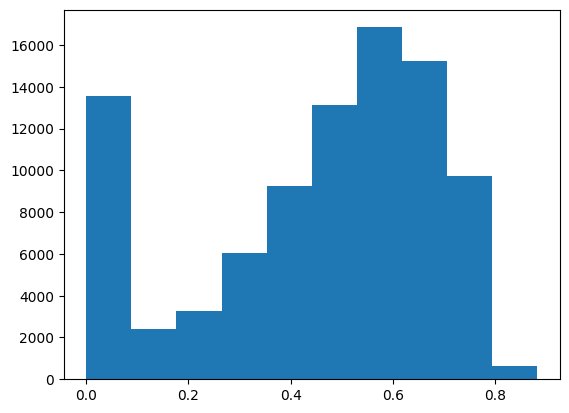

In [63]:
plt.hist(test_pred_total_mean)

In [66]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler+addfeatures.csv', index=False)